In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(pbapply)
suppressPackageStartupMessages(require(plotly))
require(viridis)
pboptions(type="timer")

source("../manuscript/functions/save_and_plot.R")

Loading required package: cowplot

Loading required package: data.table

Loading required package: ggplot2

Loading required package: pbapply

Loading required package: viridis

Loading required package: viridisLite



In [2]:
root_path = "../data/3D_David/"
#list.files(file.path(root_path))
#list.files(file.path(root_path, "DW_models"))

In [3]:
probe_meta = fread(file.path(root_path, "probes_chrX46.csv"))
#head(probe_meta)

hic_matrix = fread(file.path(root_path, "mat_hic_46plex.csv"))
#hic_matrix[1:5, 1:5]

In [4]:
hic_data = as.data.table(expand.grid(1:45, 1:45))
setnames(hic_data, LETTERS[1:2])

In [5]:
hic_data$hic_freq = as.matrix(hic_matrix)[as.matrix(hic_data[, .(A, B)])]

In [6]:
coords_dw = rbindlist(pblapply(0:195, function(file_id) {
    coords = fread(file.path(root_path, "DW_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "DW_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

coords_rl = rbindlist(pblapply(0:175, function(file_id) {
    coords = fread(file.path(root_path, "RL_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "RL_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [7]:
smatch = fread("../data/3D_David/link_rois_RL_DW.csv")
match_vector = smatch[, .(id_DW, id_RL)]
dim(match_vector)

[1] 162   2

In [8]:
hic_data_dw = rbindlist(pblapply(1:196, function(current_file_id) {
    hic_data2 = copy(hic_data)
    hic_data2$A_interpolated = coords_dw[file_id == current_file_id, interpolated][hic_data$A]
    hic_data2$B_interpolated = coords_dw[file_id == current_file_id, interpolated][hic_data$B]
    hic_data2$dist3d = as.matrix(dist(coords_dw[file_id == current_file_id, .(x, y, z)]))[as.matrix(hic_data[, .(A, B)])]
    hic_data2$file_id = current_file_id
    return(hic_data2)
}))
hic_data_dw[, method := "DW"]

hic_data_rl = rbindlist(pblapply(1:176, function(current_file_id) {
    hic_data2 = copy(hic_data)
    hic_data2$A_interpolated = coords_rl[file_id == current_file_id, interpolated][hic_data$A]
    hic_data2$B_interpolated = coords_rl[file_id == current_file_id, interpolated][hic_data$B]
    hic_data2$dist3d = as.matrix(dist(coords_rl[file_id == current_file_id, .(x, y, z)]))[as.matrix(hic_data[, .(A, B)])]
    hic_data2$file_id = current_file_id
    return(hic_data2)
}))
hic_data_rl[, method := "RL"]

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [9]:
pdata = rbindlist(list(hic_data_dw, hic_data_rl))
pdata_noInterp = pdata[!A_interpolated & !B_interpolated]

In [10]:
pdata$dlinear = abs(probe_meta[pdata$A, (Start+End)/2] - probe_meta[pdata$B, (Start+End)/2])
pdata_noInterp$dlinear = abs(probe_meta[pdata_noInterp$A, (Start+End)/2] - probe_meta[pdata_noInterp$B, (Start+End)/2])

# Average distance

In [11]:
ppdata0 = pdata[, .(hic_freq=hic_freq[1], dlinear=dlinear[1], mean_dist3d=mean(dist3d)), by=c("A", "B", "method")]
ppdata = pdata_noInterp[, .(hic_freq=hic_freq[1], dlinear=dlinear[1], mean_dist3d=mean(dist3d)), by=c("A", "B", "method")]
#head(ppdata)

# Contact frequency
Checking at different contact thresholds, from 1 to 3.2

In [12]:
cdata = rbindlist(pblapply(seq(1, 3.2, by=.2), function(thr) {
    pdata_noInterp[, .(passes_thr=dist3d < thr, dist3d, hic_freq, dlinear), by=c("A", "B", "file_id", "method")
         ][,.(hic_freq=hic_freq[1], dlinear=dlinear[1], fcontacts=sum(passes_thr)/.N, thr=thr), by=c("A", "B", "method")]
}, cl=4))
cdata0 = rbindlist(pblapply(seq(1, 3.2, by=.2), function(thr) {
    pdata[, .(passes_thr=dist3d < thr, dist3d, hic_freq, dlinear), by=c("A", "B", "file_id", "method")
         ][,.(hic_freq=hic_freq[1], dlinear=dlinear[1], fcontacts=sum(passes_thr)/.N, thr=thr), by=c("A", "B", "method")]
}, cl=4))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07s  


## Correlation between Hi-C contact frequency and structure-based contact frequency

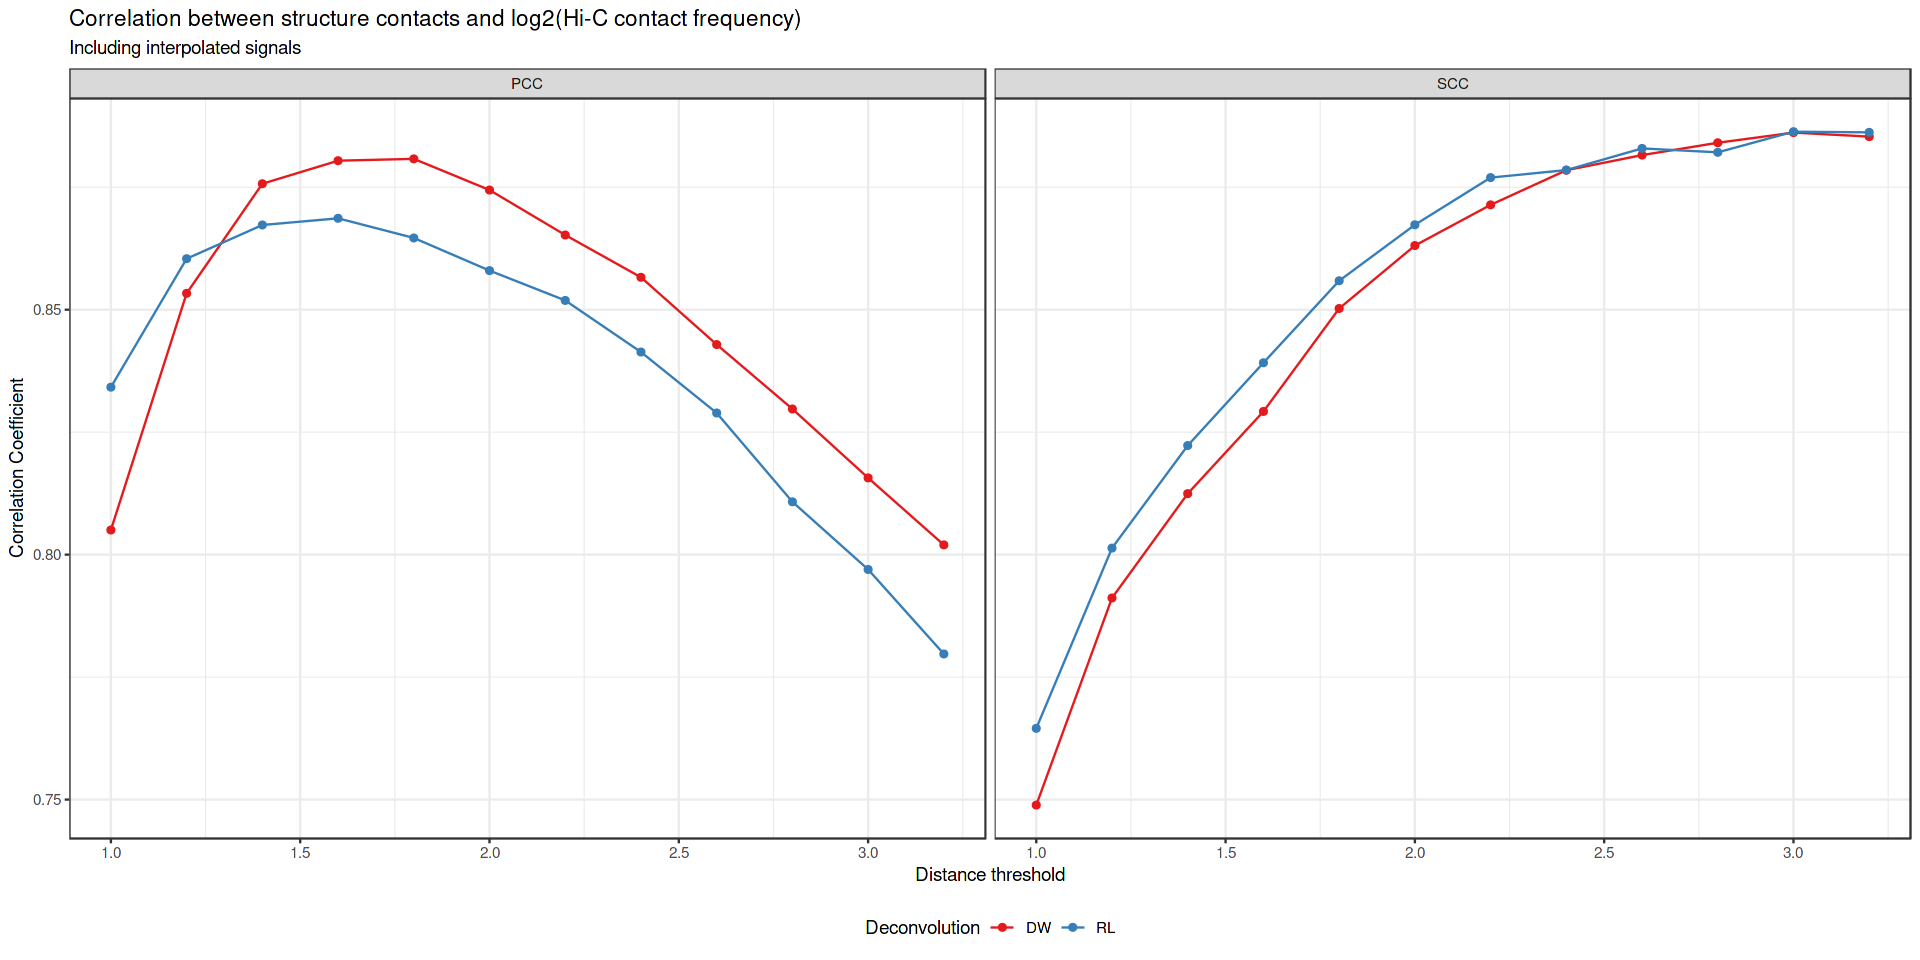

In [13]:
options(repr.plot.width=16, repr.plot.height=8)
cordata0 = cdata0[, .(PCC=cor(hic_freq, fcontacts), SCC=cor(hic_freq, fcontacts, method="spearman")), by=c("method", "thr")]
ggplot(melt(cordata0, id.vars=c("method", "thr")), aes(x=thr, y=value, color=method)) +
    geom_line() + geom_point() + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Distance threshold", y="Correlation Coefficient", color="Deconvolution", linetype="Correlation") +
    labs(title="Correlation between structure contacts and log2(Hi-C contact frequency)", subtitle="Including interpolated signals") +
    theme(legend.position="bottom") + facet_wrap(~variable)

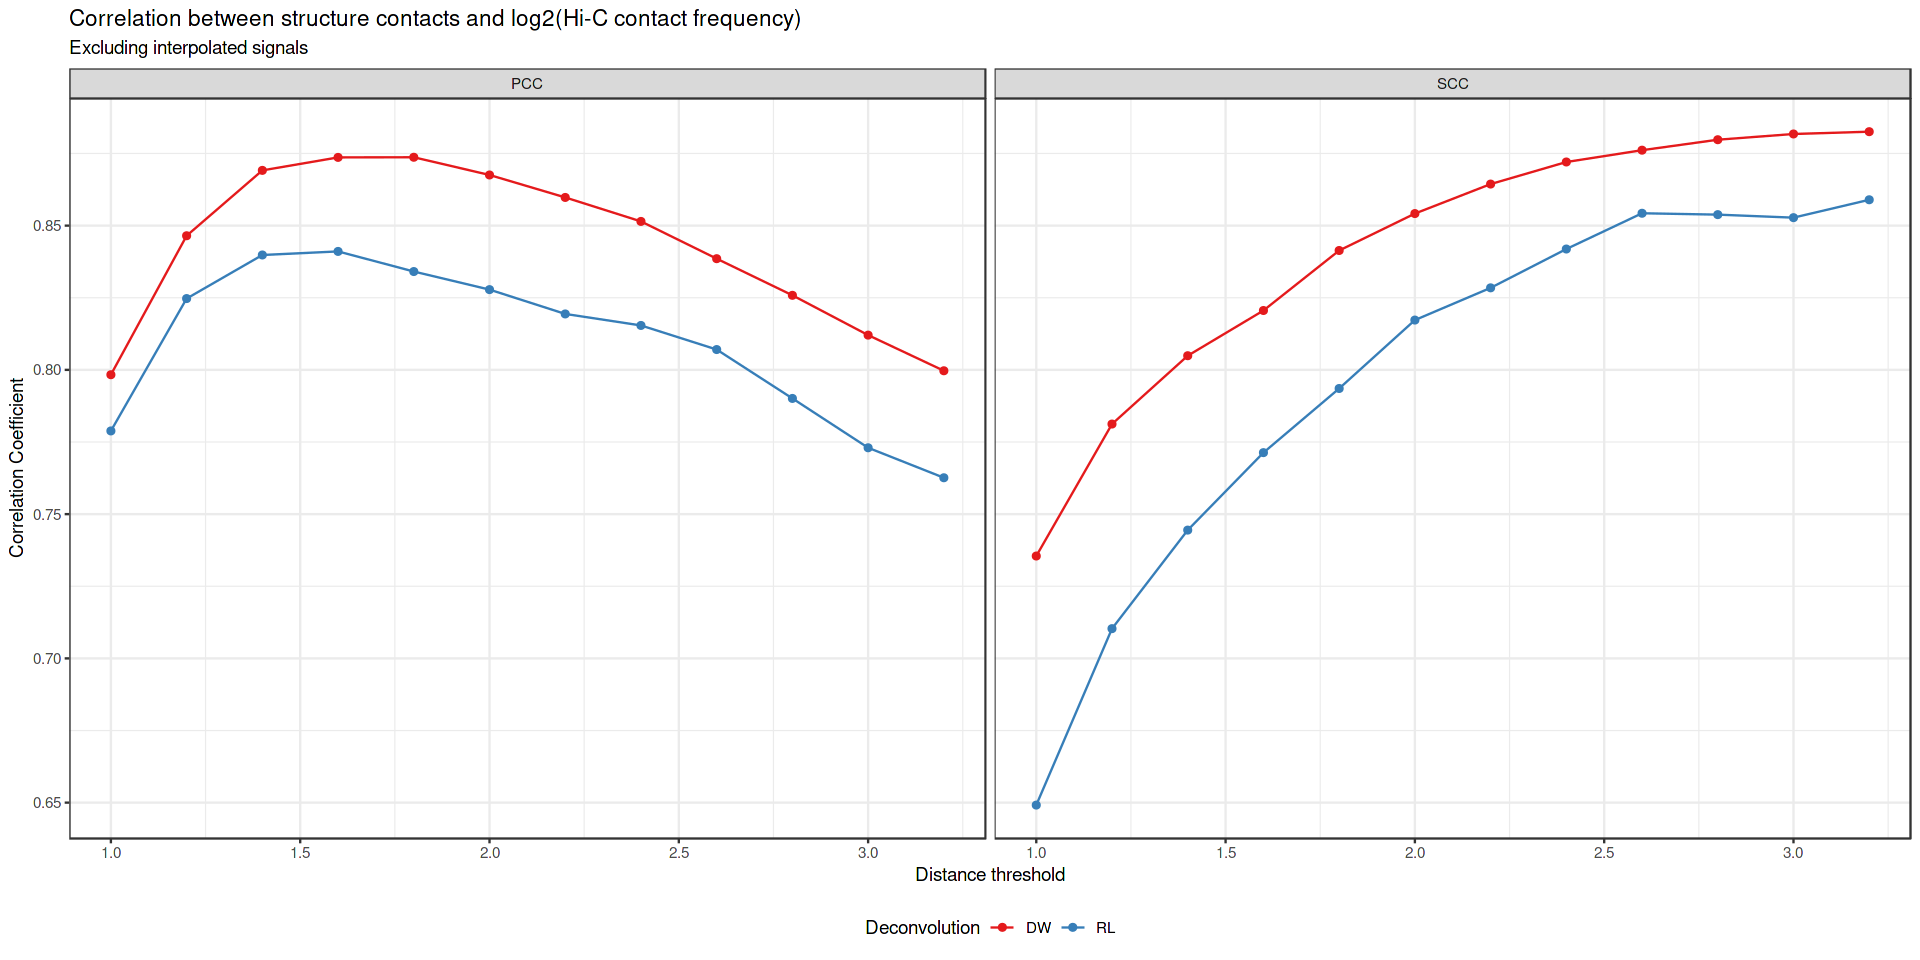

In [14]:
options(repr.plot.width=16, repr.plot.height=8)
cordata = cdata[, .(PCC=cor(hic_freq, fcontacts), SCC=cor(hic_freq, fcontacts, method="spearman")), by=c("method", "thr")]
ggplot(melt(cordata, id.vars=c("method", "thr")), aes(x=thr, y=value, color=method)) +
    geom_line() + geom_point() + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Distance threshold", y="Correlation Coefficient", color="Deconvolution", linetype="Correlation") +
    labs(title="Correlation between structure contacts and log2(Hi-C contact frequency)", subtitle="Excluding interpolated signals") +
    theme(legend.position="bottom") + facet_wrap(~variable)

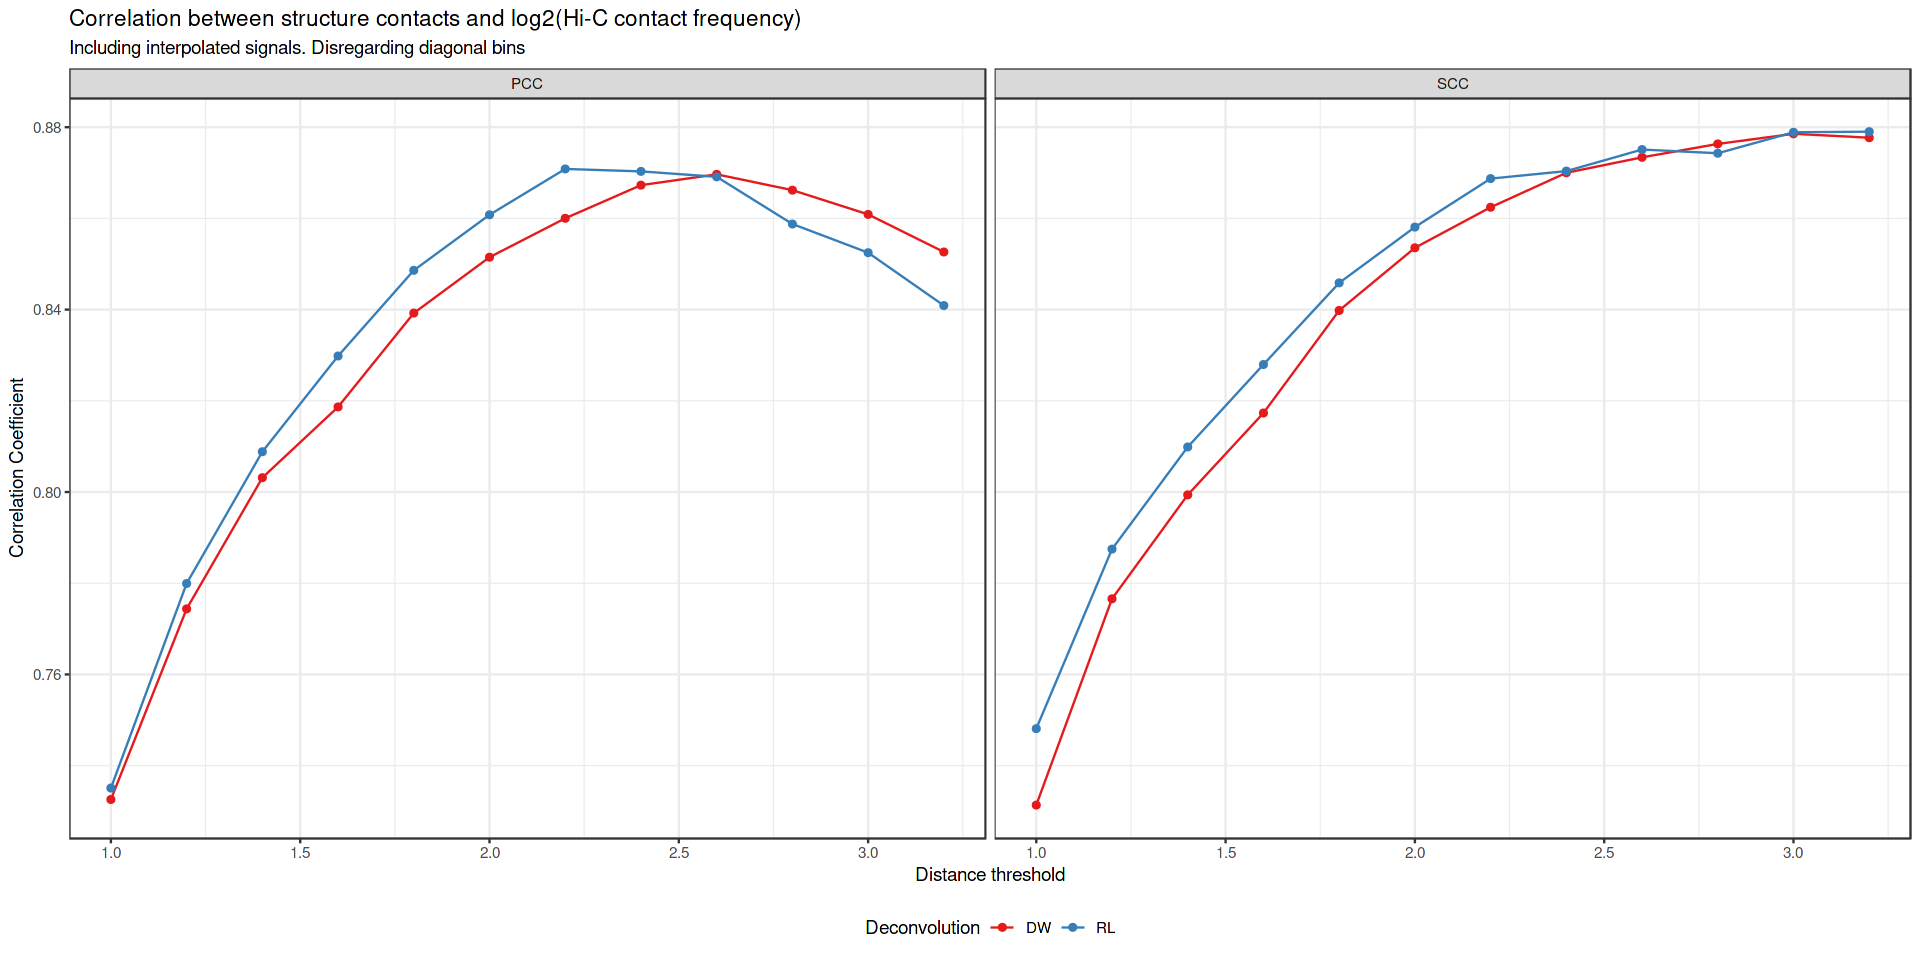

In [15]:
options(repr.plot.width=16, repr.plot.height=8)
cordata0 = cdata0[dlinear != 0, .(PCC=cor(hic_freq, fcontacts), SCC=cor(hic_freq, fcontacts, method="spearman")), by=c("method", "thr")]
ggplot(melt(cordata0, id.vars=c("method", "thr")), aes(x=thr, y=value, color=method)) +
    geom_line() + geom_point() + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Distance threshold", y="Correlation Coefficient", color="Deconvolution", linetype="Correlation") +
    labs(title="Correlation between structure contacts and log2(Hi-C contact frequency)", subtitle="Including interpolated signals. Disregarding diagonal bins") +
    theme(legend.position="bottom") + facet_wrap(~variable)

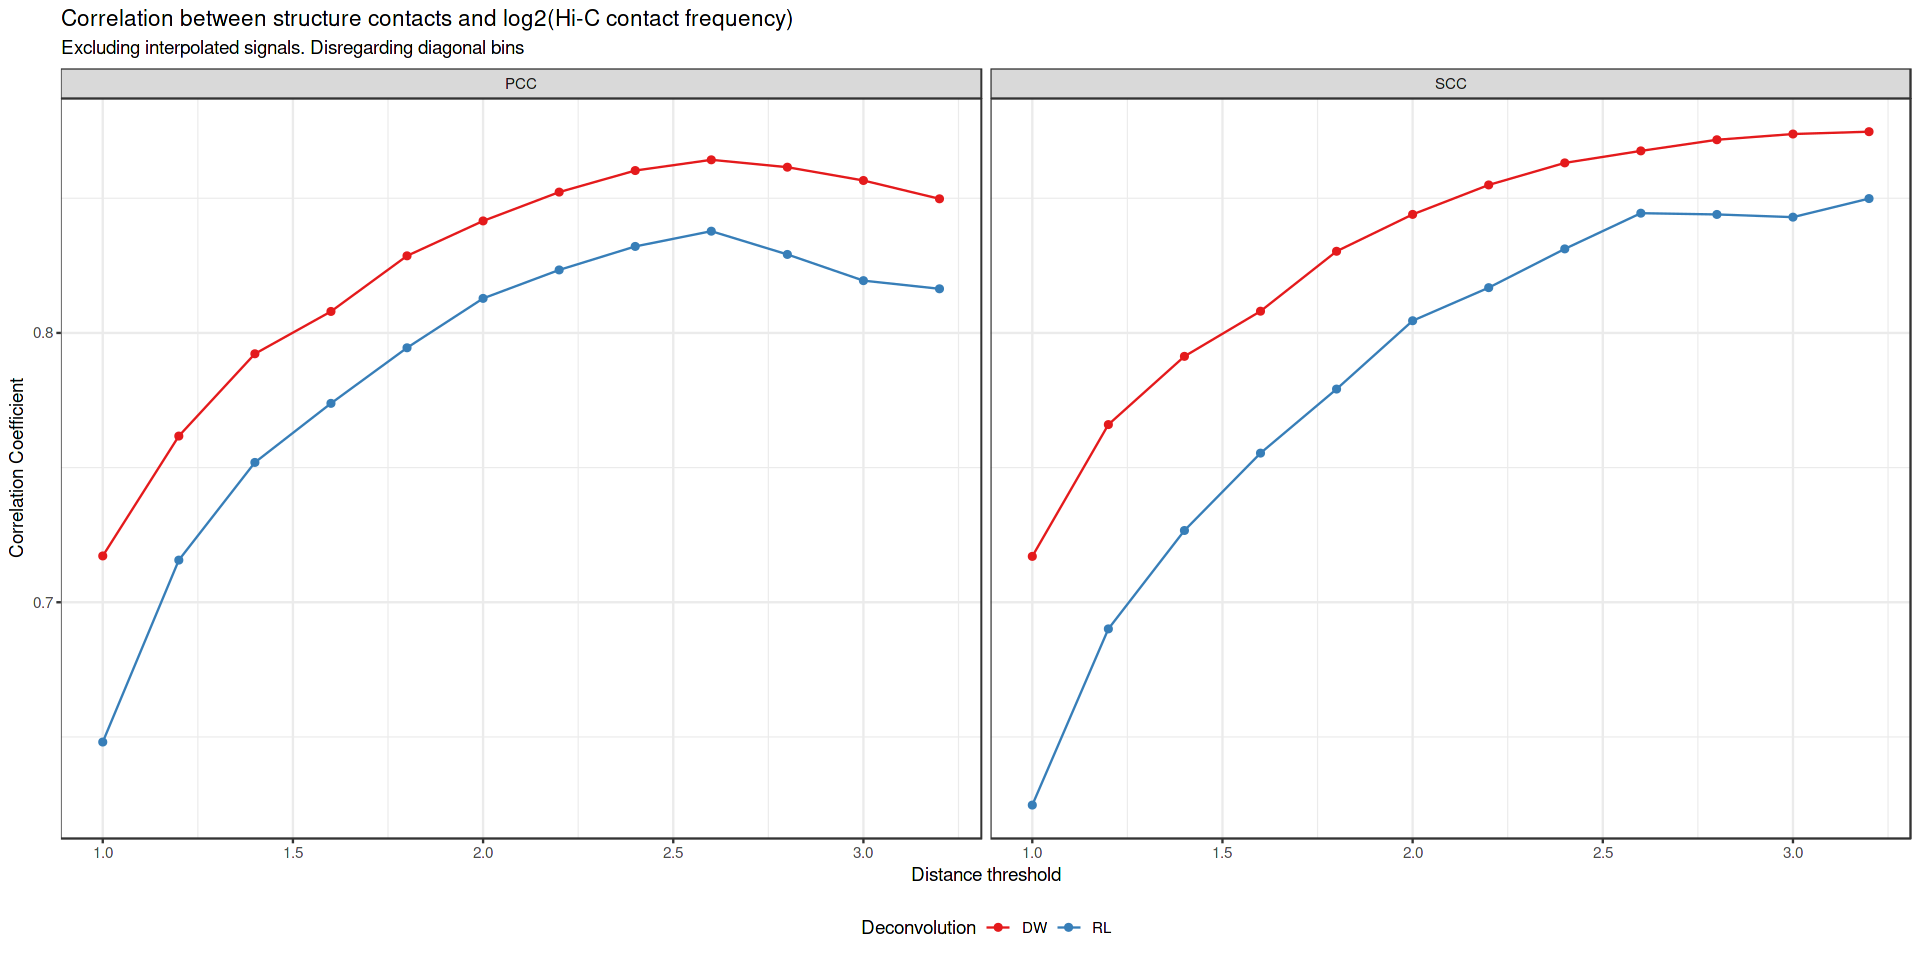

In [16]:
options(repr.plot.width=16, repr.plot.height=8)
cordata = cdata[dlinear != 0, .(PCC=cor(hic_freq, fcontacts), SCC=cor(hic_freq, fcontacts, method="spearman")), by=c("method", "thr")]
ggplot(melt(cordata, id.vars=c("method", "thr")), aes(x=thr, y=value, color=method)) +
    geom_line() + geom_point() + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Distance threshold", y="Correlation Coefficient", color="Deconvolution", linetype="Correlation") +
    labs(title="Correlation between structure contacts and log2(Hi-C contact frequency)", subtitle="Excluding interpolated signals. Disregarding diagonal bins") +
    theme(legend.position="bottom") + facet_wrap(~variable)

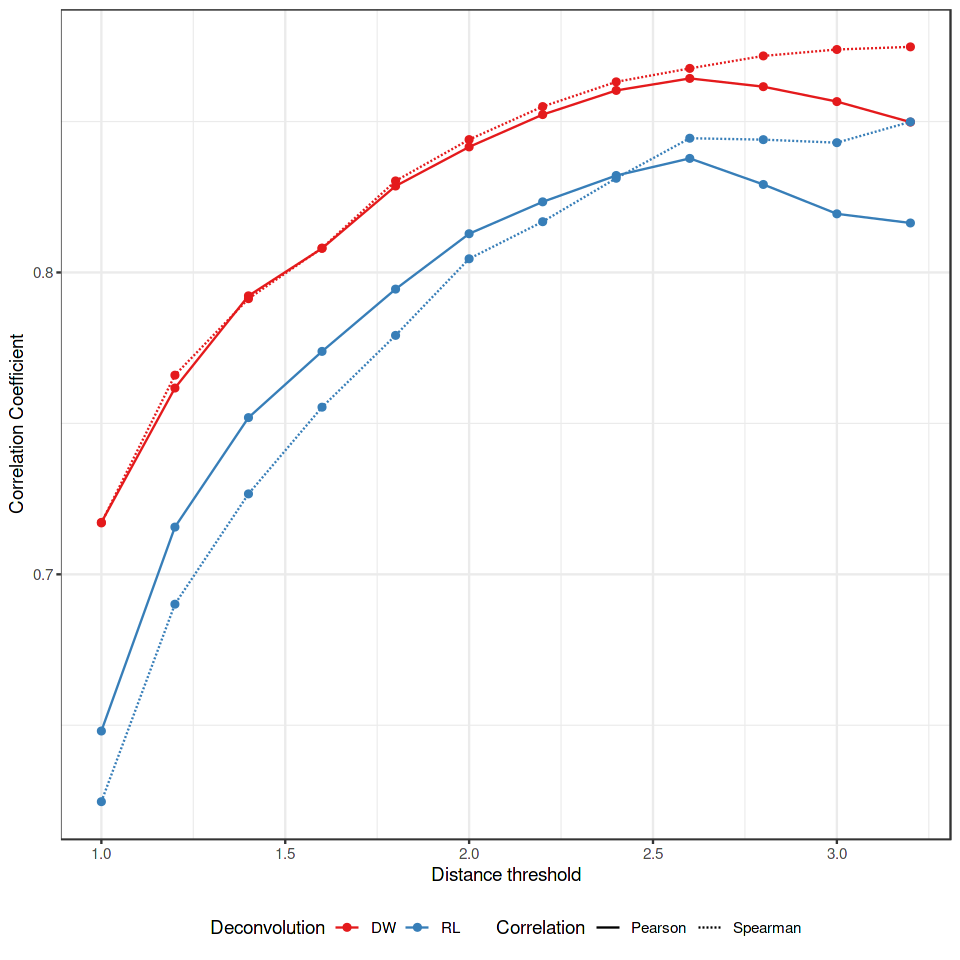

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
cordata = cdata[dlinear != 0, .(Pearson=cor(hic_freq, fcontacts), Spearman=cor(hic_freq, fcontacts, method="spearman")), by=c("method", "thr")]
p = ggplot(melt(cordata, id.vars=c("method", "thr")), aes(x=thr, y=value, color=method)) +
    geom_line(aes(linetype=variable)) + geom_point() + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Distance threshold", y="Correlation Coefficient", color="Deconvolution", linetype="Correlation") +
    theme(legend.position="bottom")
print(p)
save_and_plot(p, "plots/hic_struct.contact_freq.corr", width=8, height=8, formats=c("png", "jpg", "pdf"))

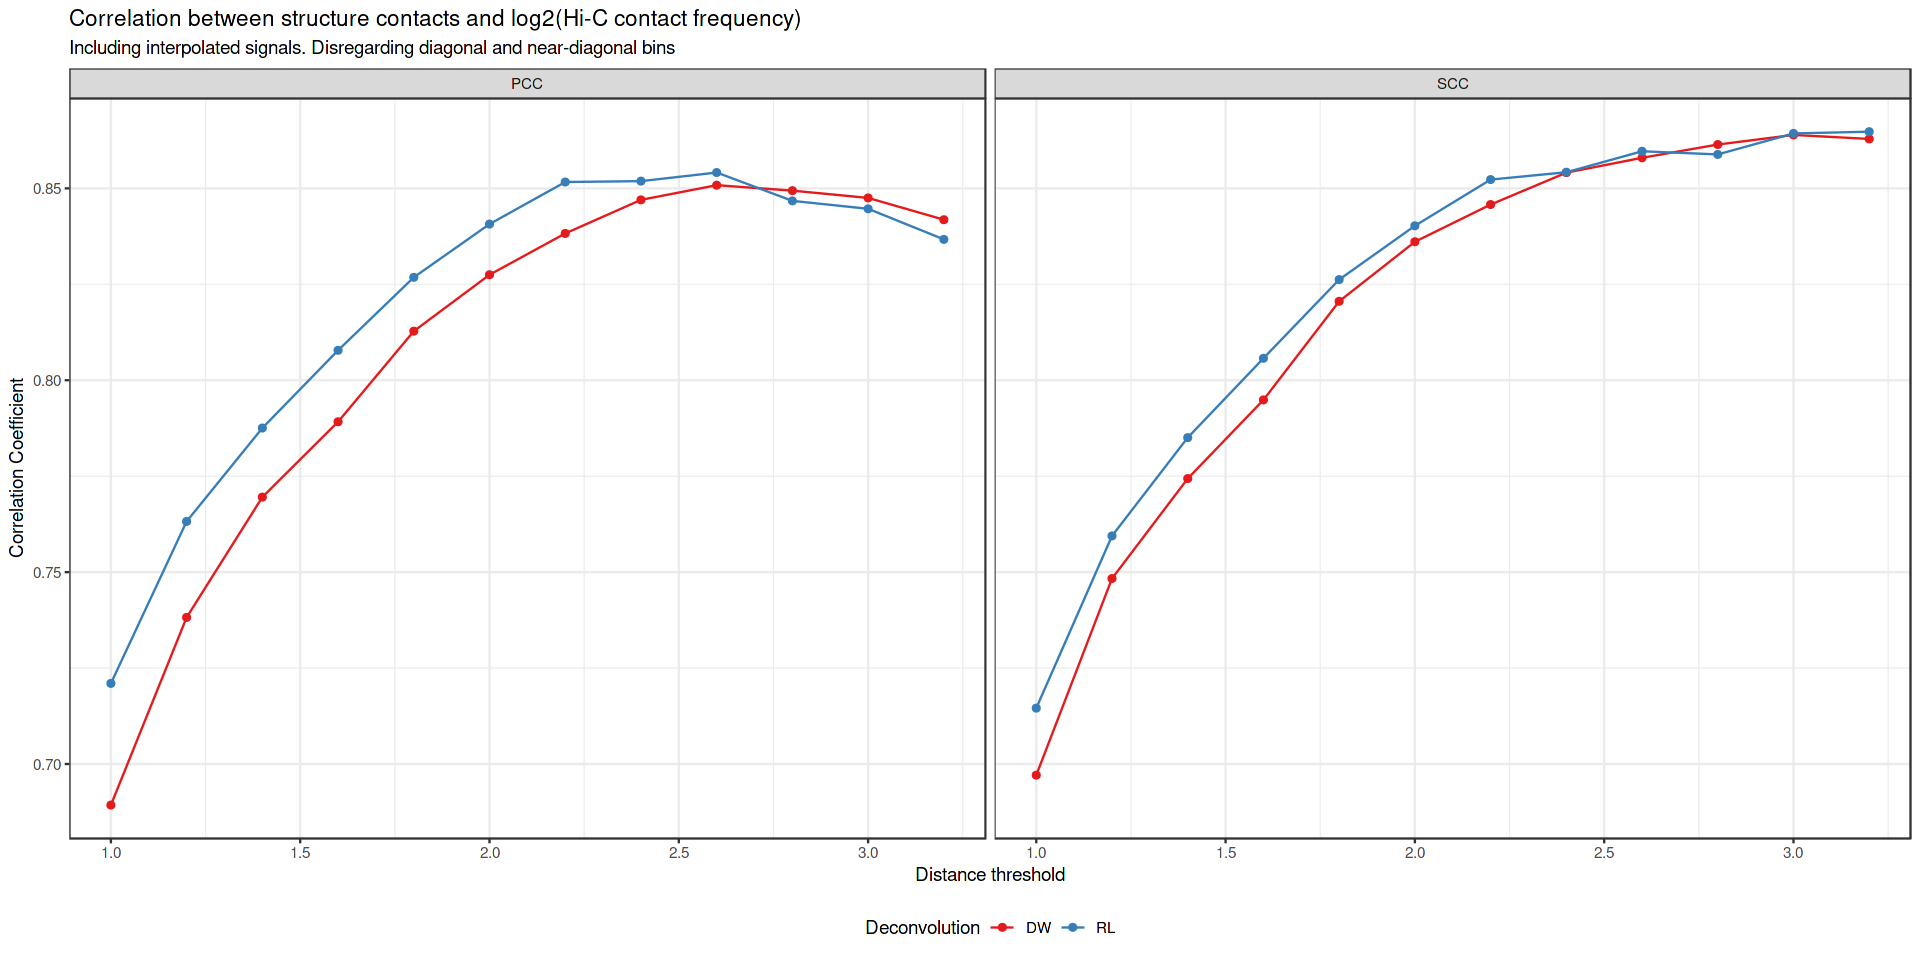

In [19]:
options(repr.plot.width=16, repr.plot.height=8)
cordata0 = cdata0[abs(A-B) >= 2, .(PCC=cor(hic_freq, fcontacts), SCC=cor(hic_freq, fcontacts, method="spearman")), by=c("method", "thr")]
ggplot(melt(cordata0, id.vars=c("method", "thr")), aes(x=thr, y=value, color=method)) +
    geom_line() + geom_point() + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Distance threshold", y="Correlation Coefficient", color="Deconvolution", linetype="Correlation") +
    labs(title="Correlation between structure contacts and log2(Hi-C contact frequency)", subtitle="Including interpolated signals. Disregarding diagonal and near-diagonal bins") +
    theme(legend.position="bottom") + facet_wrap(~variable)

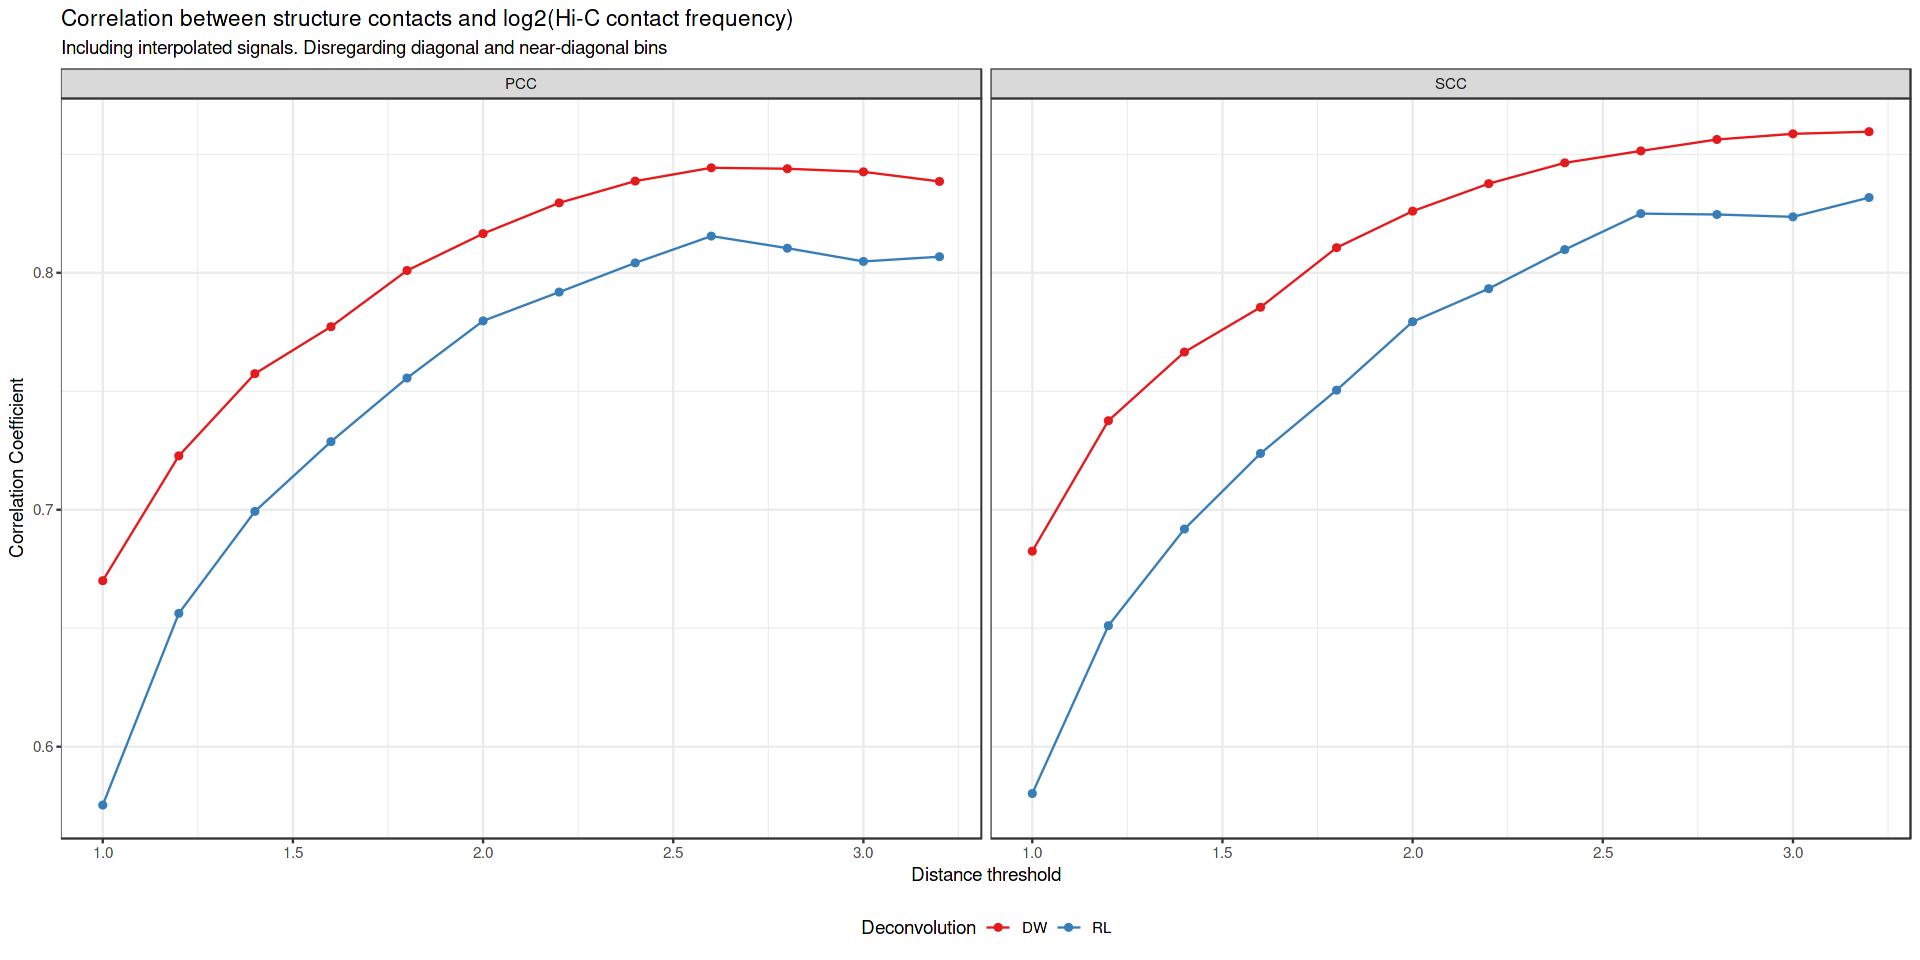

In [20]:
options(repr.plot.width=16, repr.plot.height=8)
cordata = cdata[abs(A-B) >= 2, .(PCC=cor(hic_freq, fcontacts), SCC=cor(hic_freq, fcontacts, method="spearman")), by=c("method", "thr")]
ggplot(melt(cordata, id.vars=c("method", "thr")), aes(x=thr, y=value, color=method)) +
    geom_line() + geom_point() + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Distance threshold", y="Correlation Coefficient", color="Deconvolution", linetype="Correlation") +
    labs(title="Correlation between structure contacts and log2(Hi-C contact frequency)", subtitle="Including interpolated signals. Disregarding diagonal and near-diagonal bins") +
    theme(legend.position="bottom") + facet_wrap(~variable)

## Heatmap

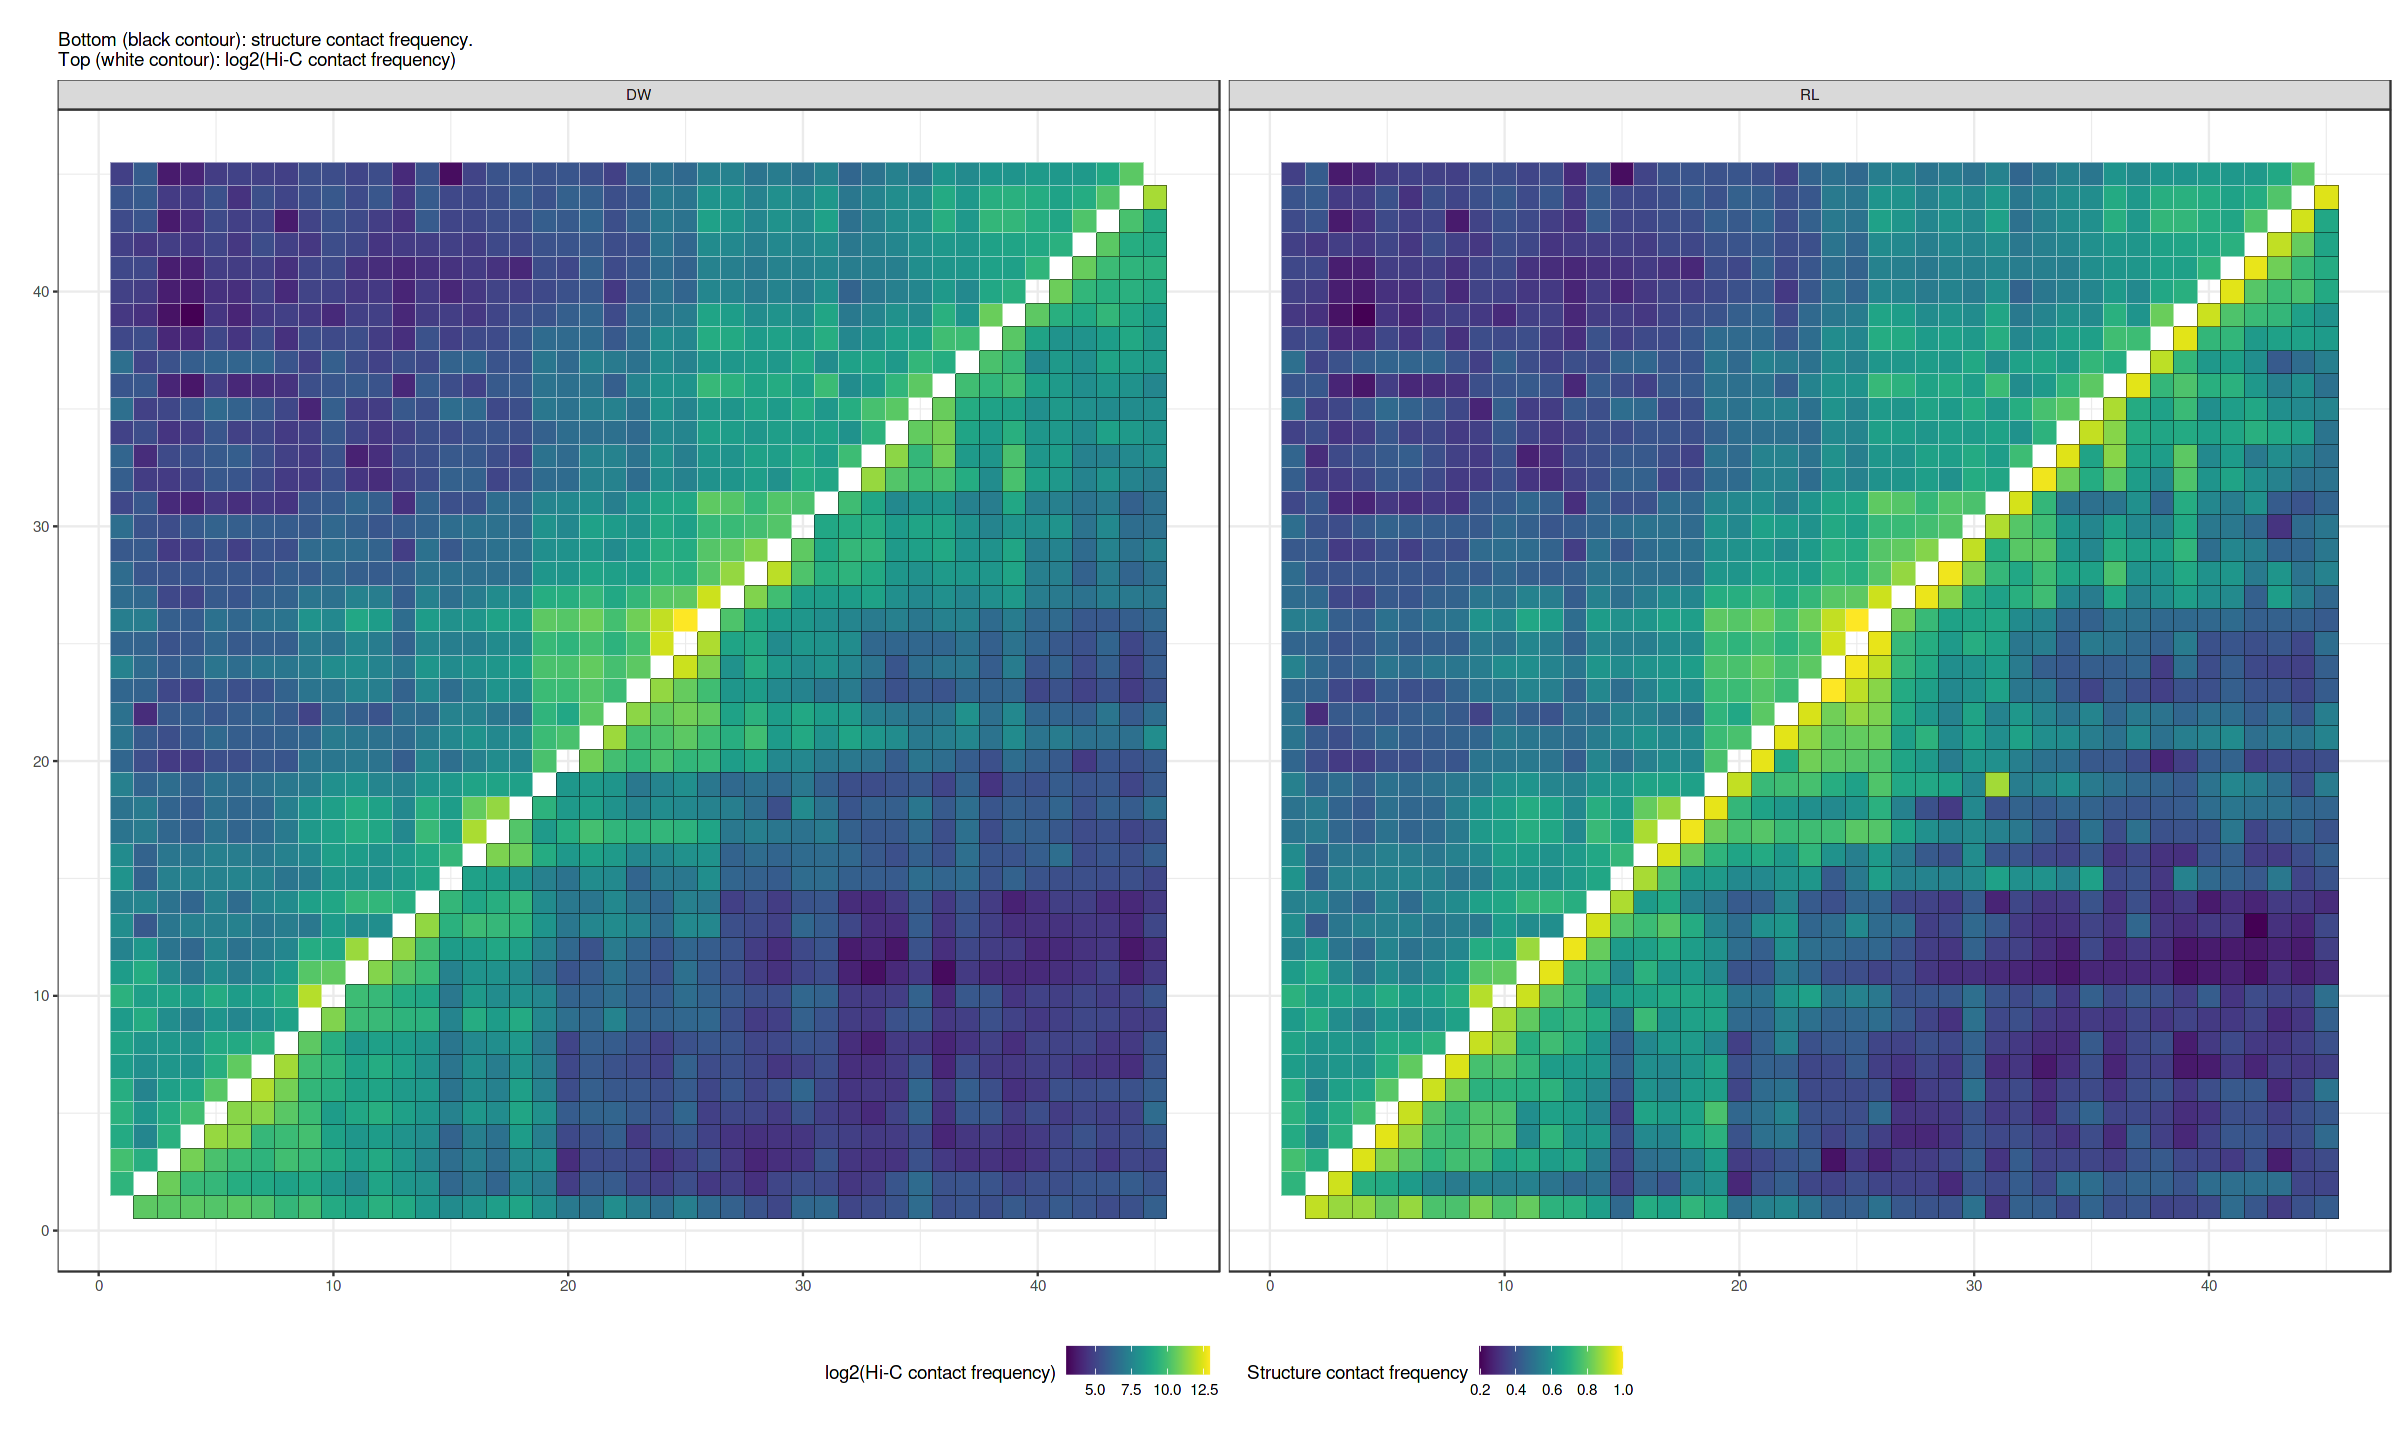

In [74]:
hmdata = cdata[dlinear != 0][thr == 2]
require(ggnewscale)
options(repr.plot.width=20, repr.plot.height=12)
p = ggplot(hmdata[A > B]) +
    geom_tile(aes(x=A, y=B, fill=fcontacts), color="black") +
    scale_fill_viridis("Structure contact frequency") +
    new_scale("fill") +
    geom_tile(aes(x=B, y=A, fill=hic_freq), color="white") +
    scale_fill_viridis("log2(Hi-C contact frequency)") +
    coord_fixed() + theme_bw() +
    theme(legend.position="bottom") +
    labs(x="", y="", subtitle="Bottom (black contour): structure contact frequency.\nTop (white contour): log2(Hi-C contact frequency)") +
    facet_wrap(~method)
print(p)
save_and_plot(p, "plots/heatmap.hic_struct.contact_freq", height=12, width=20, formats=c("jpg", "png", "pdf"))

In [76]:
hmdata[, hic_freq_norm := (hic_freq-min(hic_freq))/(max(hic_freq)-min(hic_freq))]

A B method hic_freq dlinear  fcontacts thr hic_freq_norm
1 2 1 DW     9.467606  3429167 0.7989130 2   0.6509329    
2 3 1 DW     9.962896  6941905 0.7912088 2   0.7007815    
3 4 1 DW     9.030667 10502876 0.7947368 2   0.6069572    
4 5 1 DW     9.350939 13950466 0.7835052 2   0.6391910    
5 6 1 DW     9.199672 17237482 0.7936508 2   0.6239668    
6 7 1 DW     8.507795 19558918 0.7743590 2   0.5543326

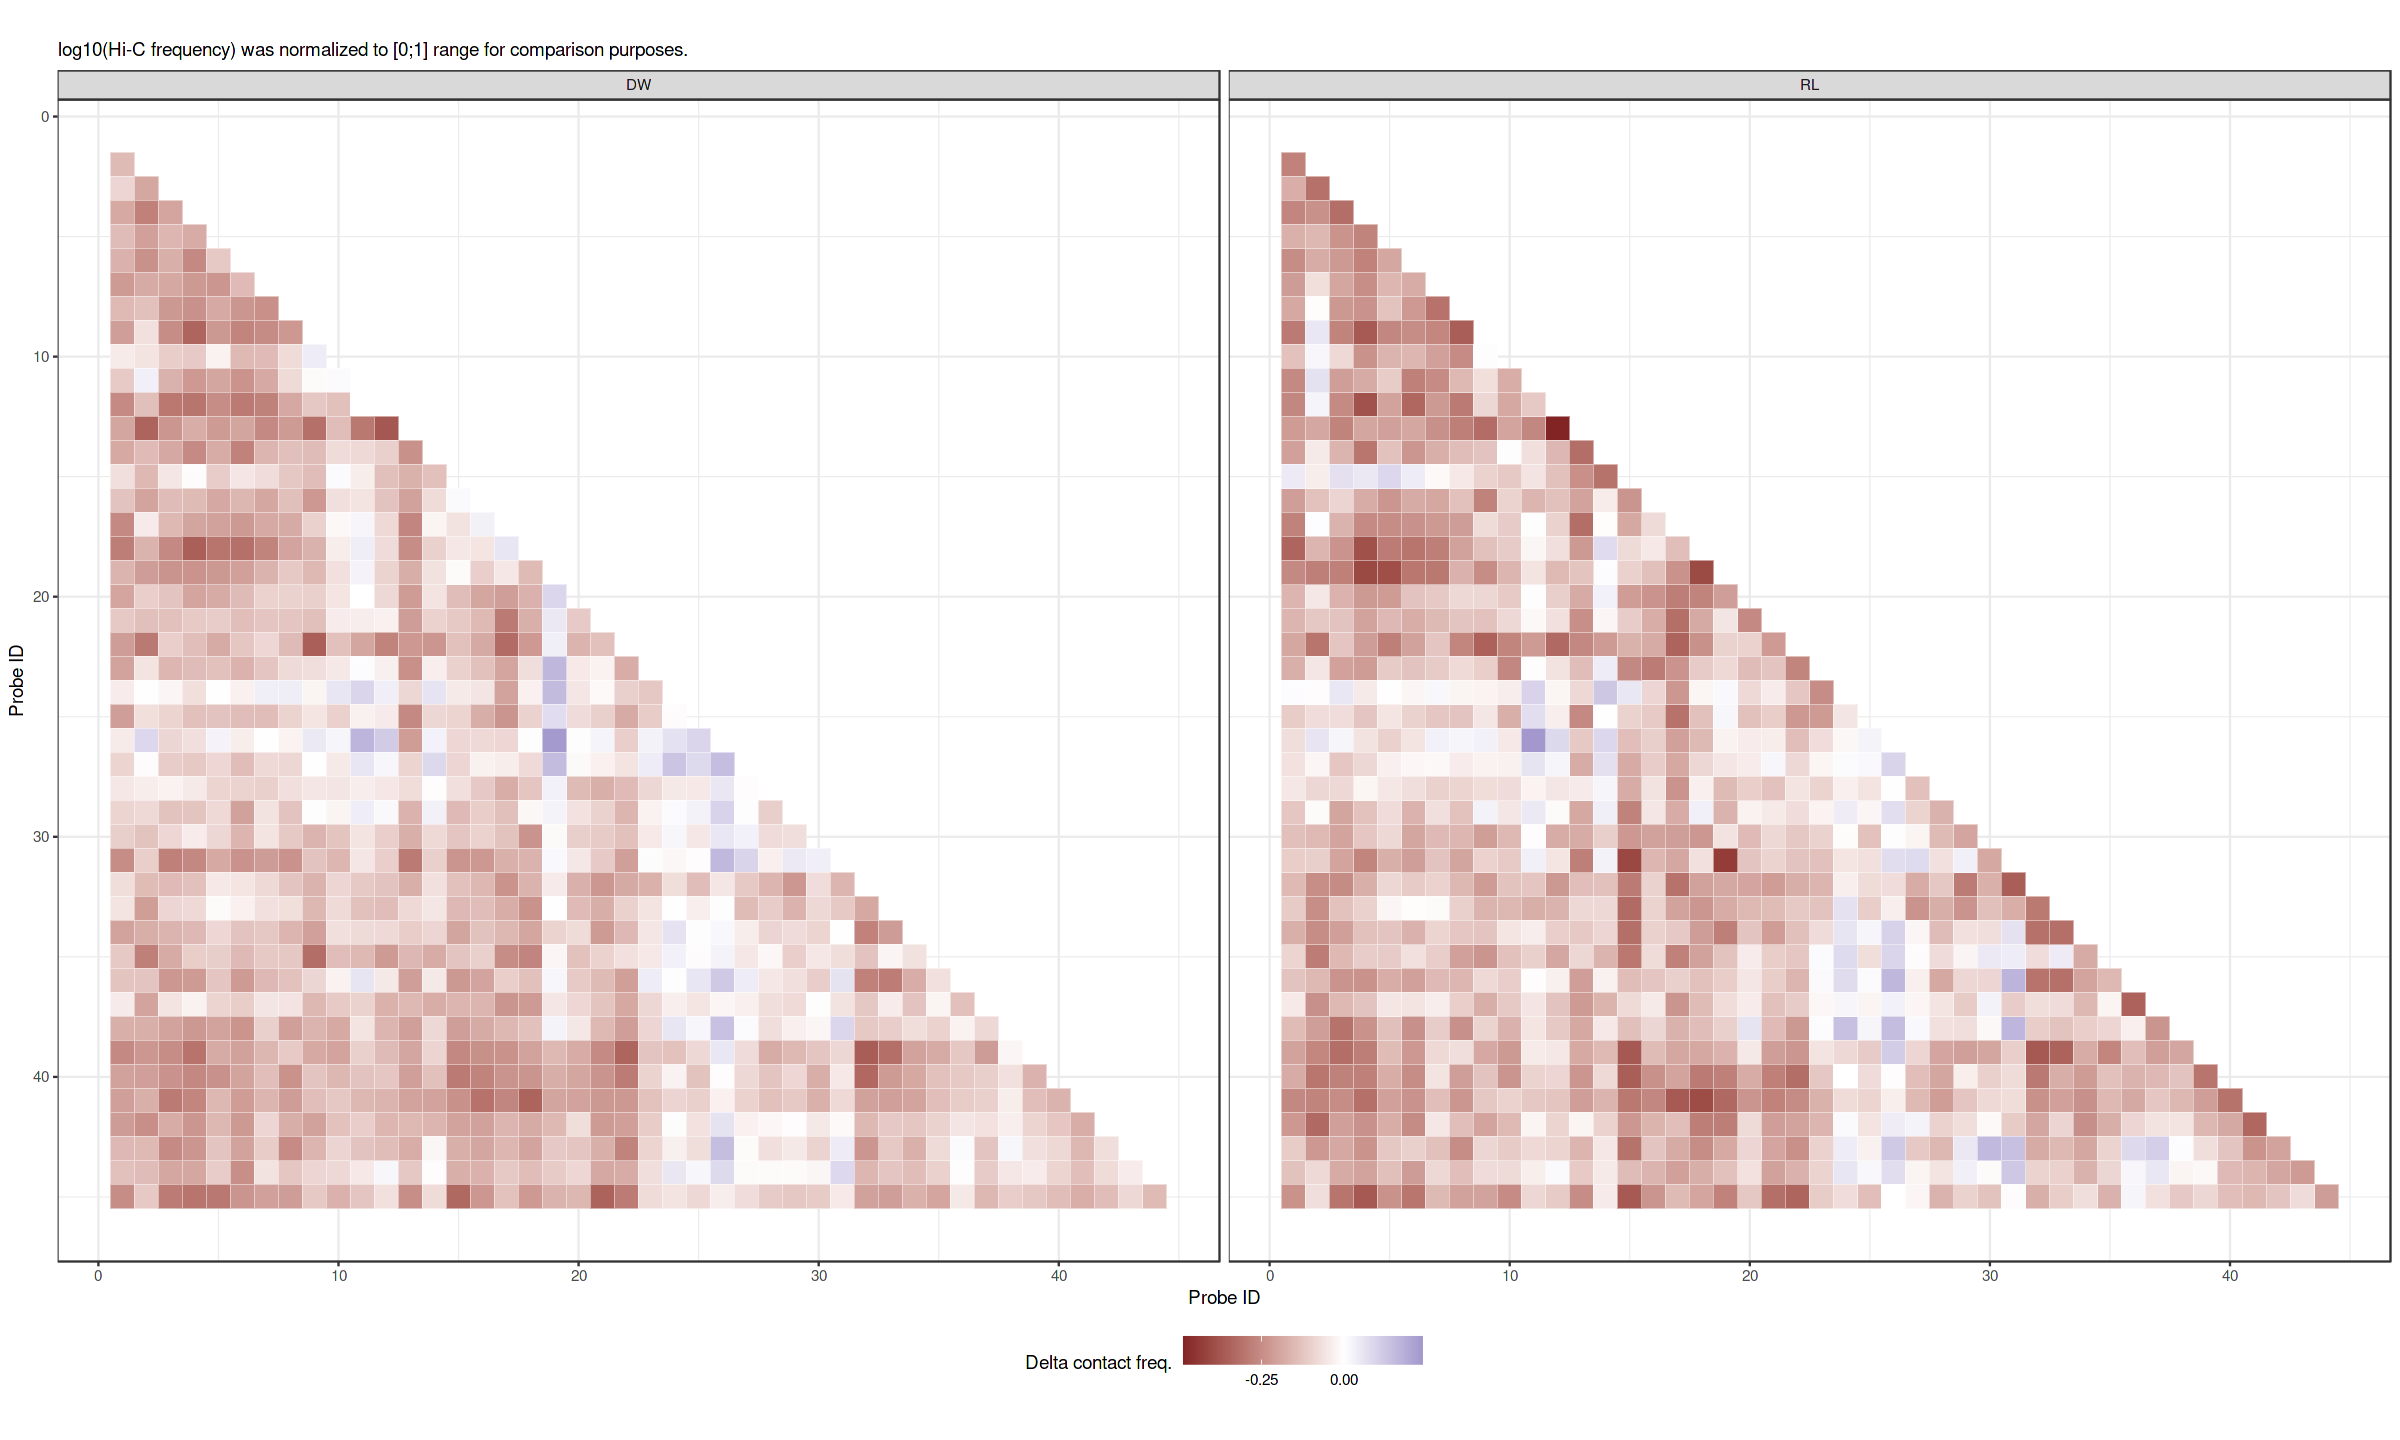

In [85]:
p = ggplot(hmdata[A<B], aes(x=A, y=B, fill=hic_freq_norm-fcontacts)) + geom_tile(color="white") +
    coord_fixed() + theme_bw() + scale_y_reverse() + facet_wrap(~method) +
    scale_fill_gradient2() + labs(x="Probe ID", y="Probe ID", fill="Delta contact freq.") +
    labs(subtitle="log10(Hi-C frequency) was normalized to [0;1] range for comparison purposes.") +
    theme(legend.position="bottom") + guides(fill=guide_colorbar(barwidth=10))
print(p)
save_and_plot(p, "plots/heatmap_cmp.hic_struct.contact_freq.delta", height=12, width=20, formats=c("jpg", "png", "pdf"))

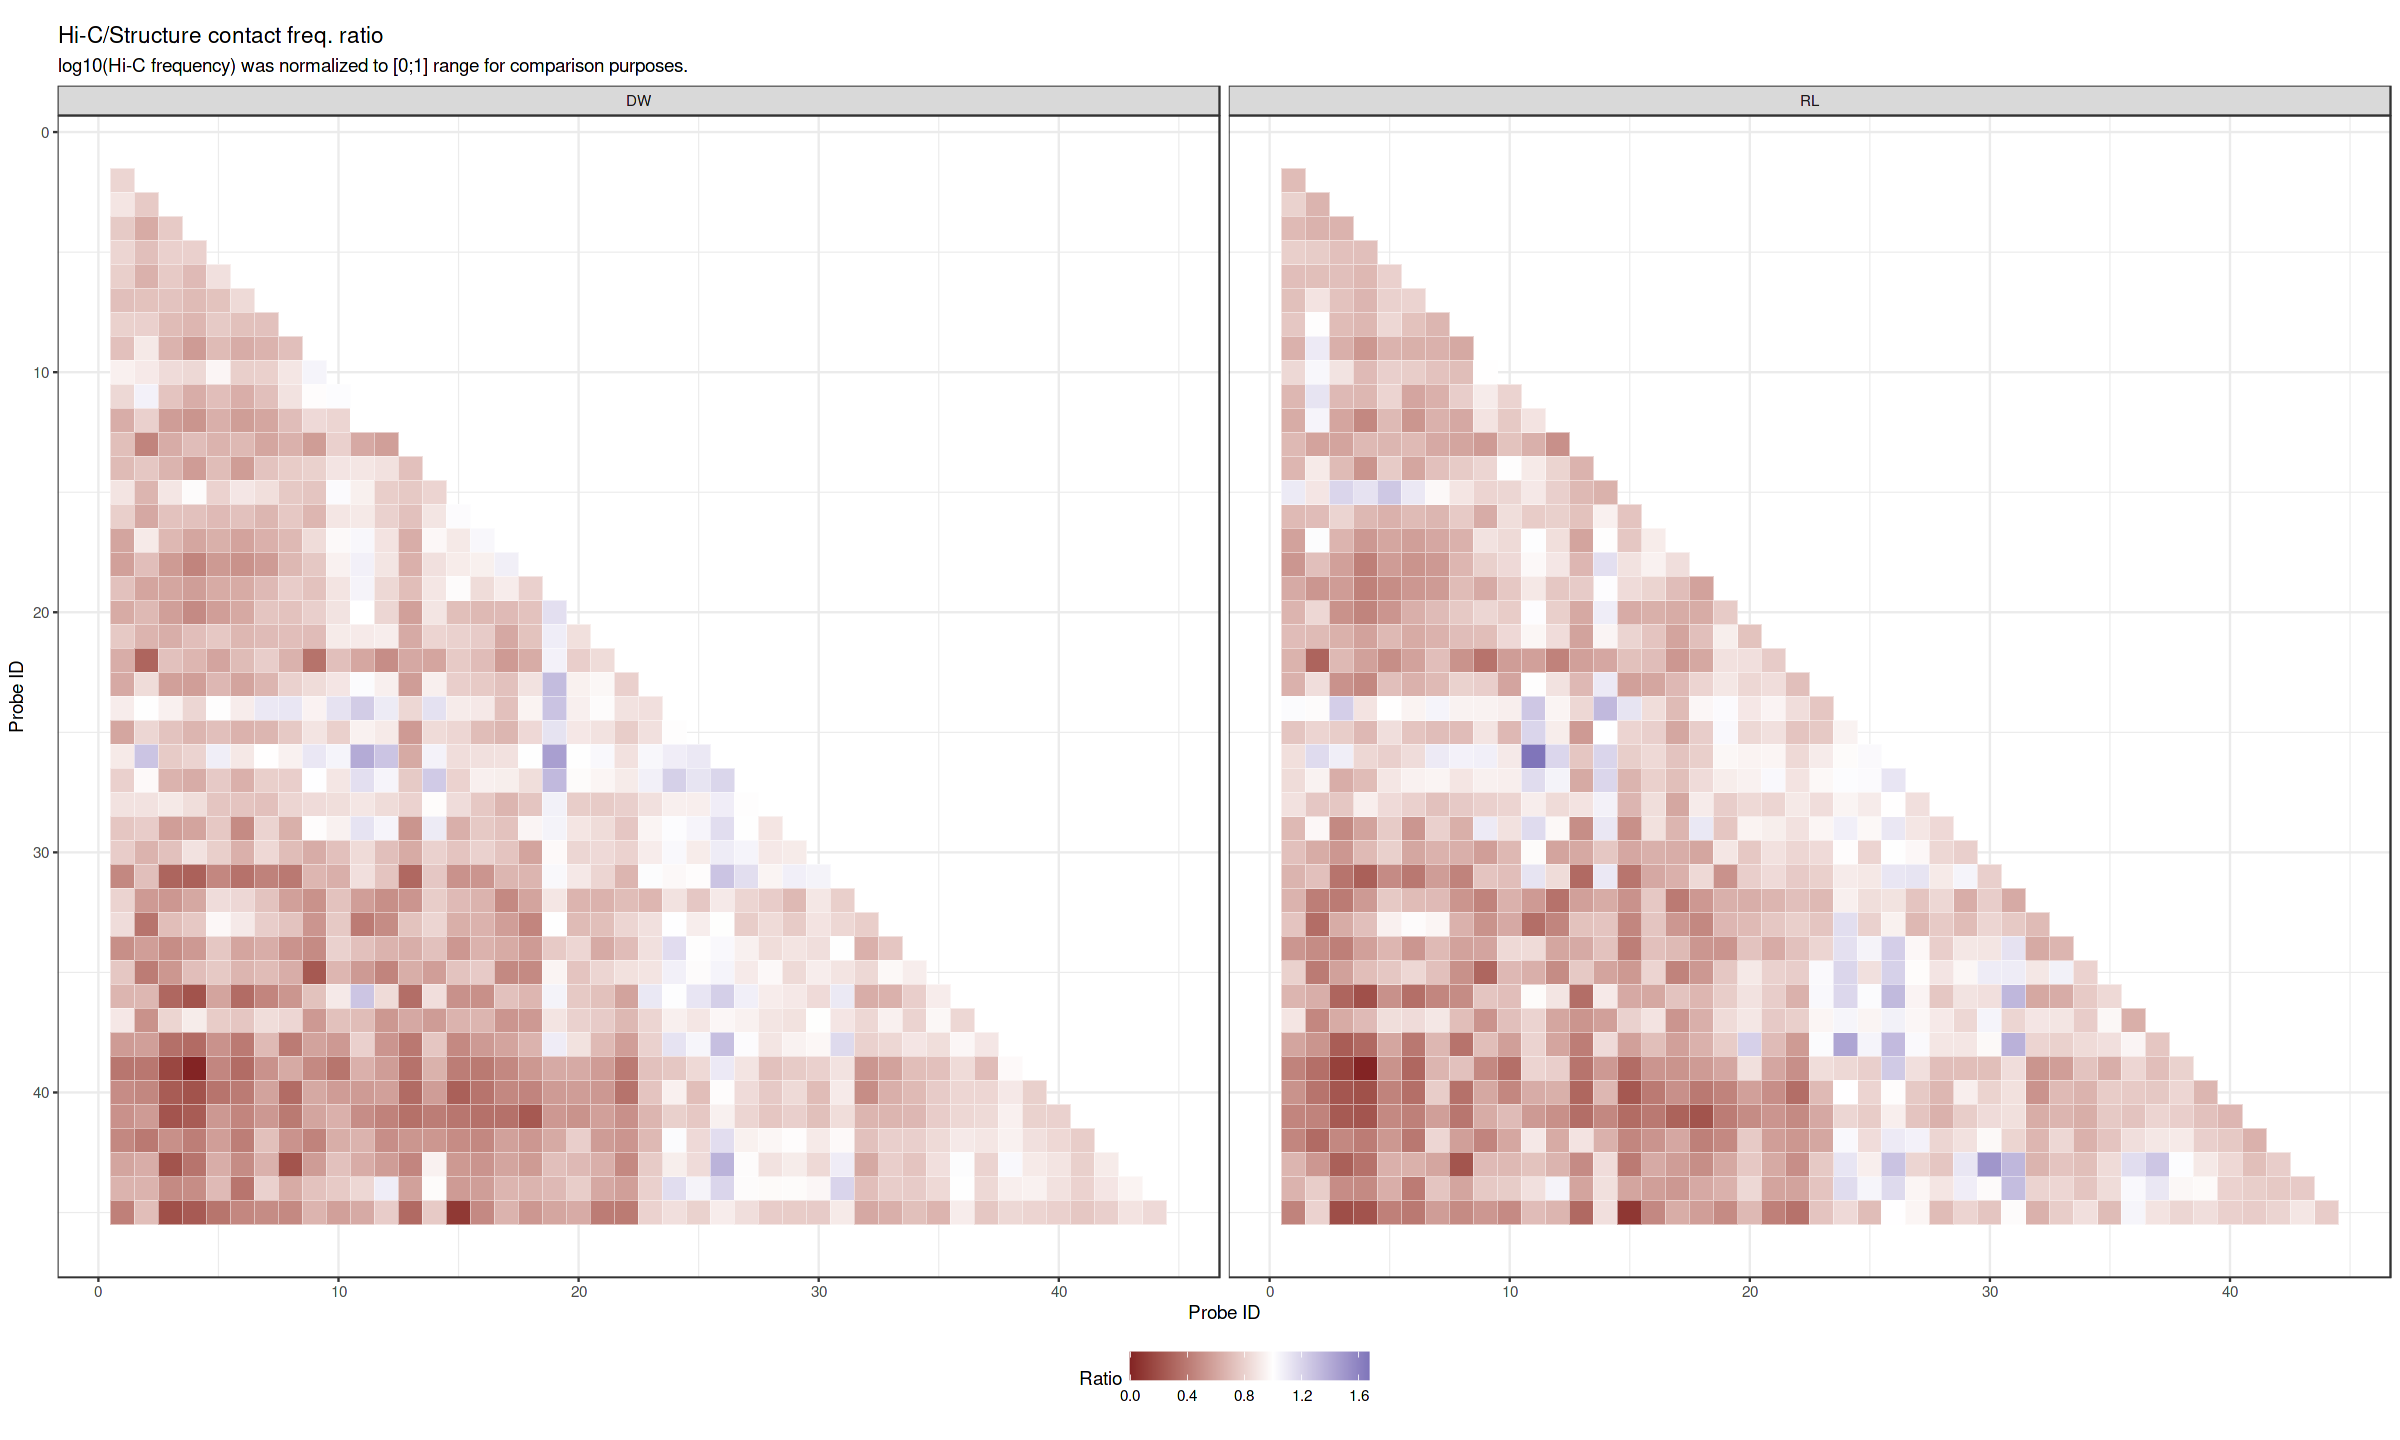

In [86]:
p = ggplot(hmdata[A<B], aes(x=A, y=B, fill=hic_freq_norm/fcontacts)) + geom_tile(color="white") +
    coord_fixed() + theme_bw() + scale_y_reverse() + facet_wrap(~method) +
    scale_fill_gradient2(midpoint=1) + labs(x="Probe ID", y="Probe ID", fill="Ratio") +
    labs(subtitle="log10(Hi-C frequency) was normalized to [0;1] range for comparison purposes.") +
    labs(title="Hi-C/Structure contact freq. ratio") + theme(legend.position="bottom") + guides(fill=guide_colorbar(barwidth=10))
print(p)
save_and_plot(p, "plots/heatmap_cmp.hic_struct.contact_freq.ratio", height=12, width=20, formats=c("jpg", "png", "pdf"))

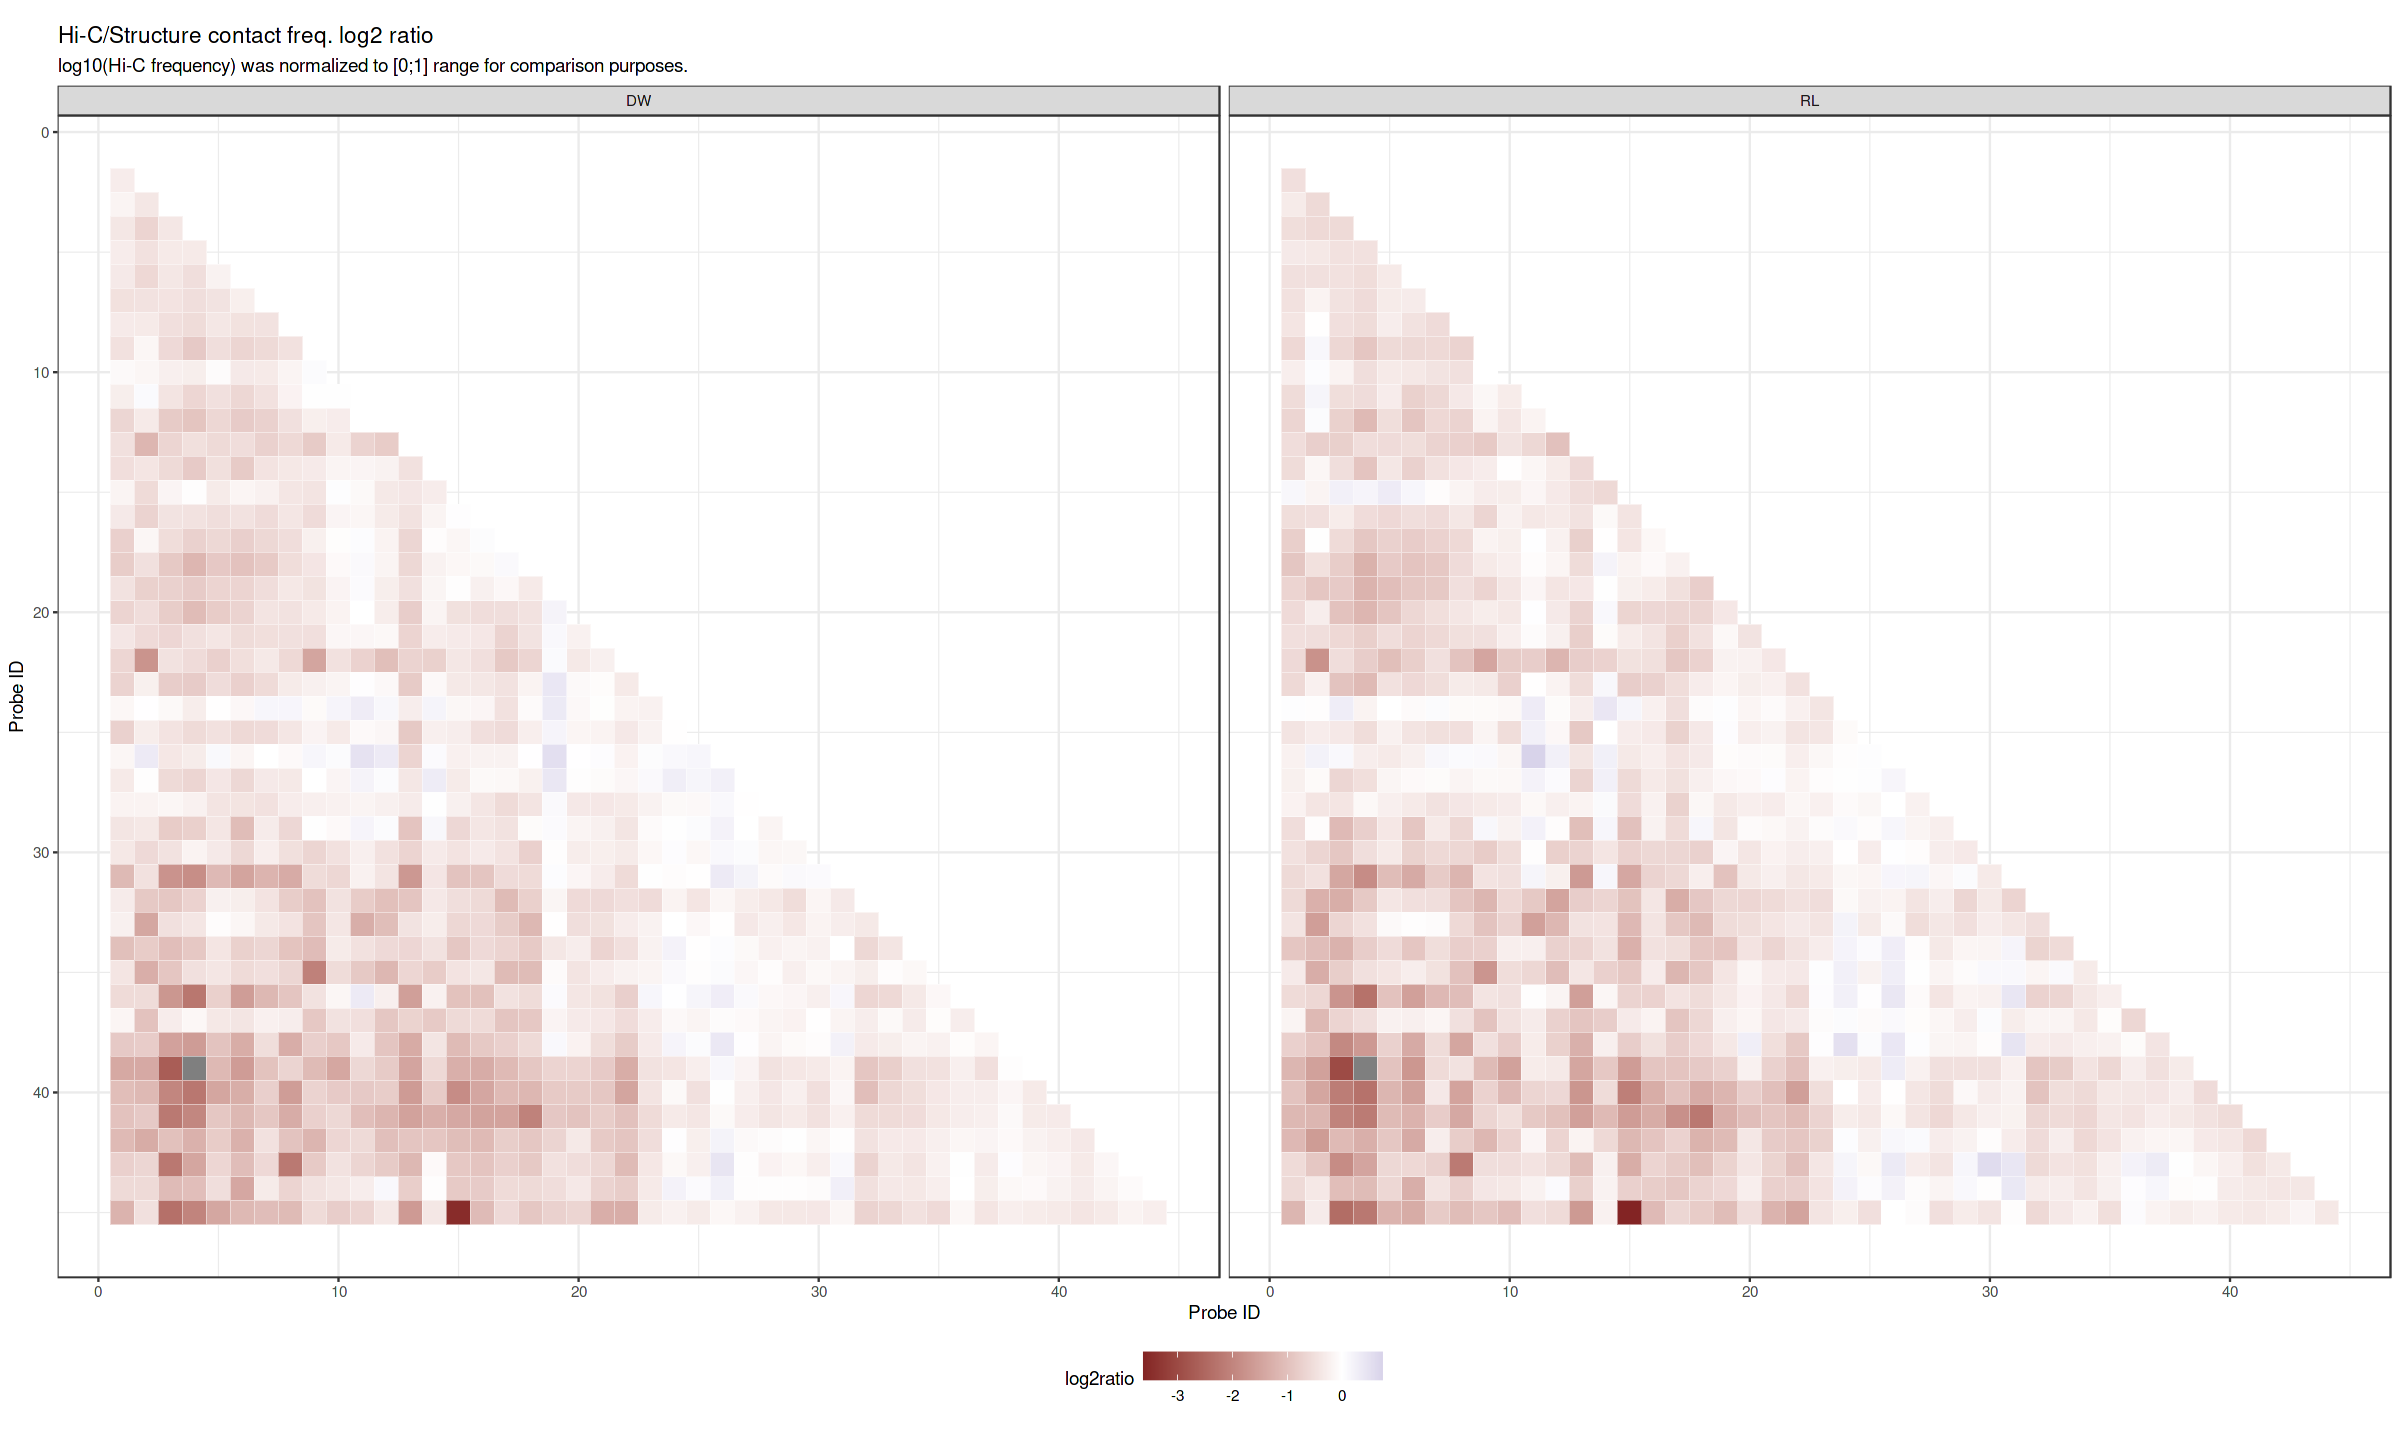

In [87]:
p = ggplot(hmdata[A<B], aes(x=A, y=B, fill=log2(hic_freq_norm/fcontacts))) + geom_tile(color="white") +
    coord_fixed() + theme_bw() + scale_y_reverse() + facet_wrap(~method) +
    scale_fill_gradient2() + labs(x="Probe ID", y="Probe ID", fill="log2ratio") +
    labs(subtitle="log10(Hi-C frequency) was normalized to [0;1] range for comparison purposes.") +
    labs(title="Hi-C/Structure contact freq. log2 ratio") + theme(legend.position="bottom") + guides(fill=guide_colorbar(barwidth=10))
print(p)
save_and_plot(p, "plots/heatmap_cmp.hic_struct.contact_freq.log2ratio", height=12, width=20, formats=c("jpg", "png", "pdf"))

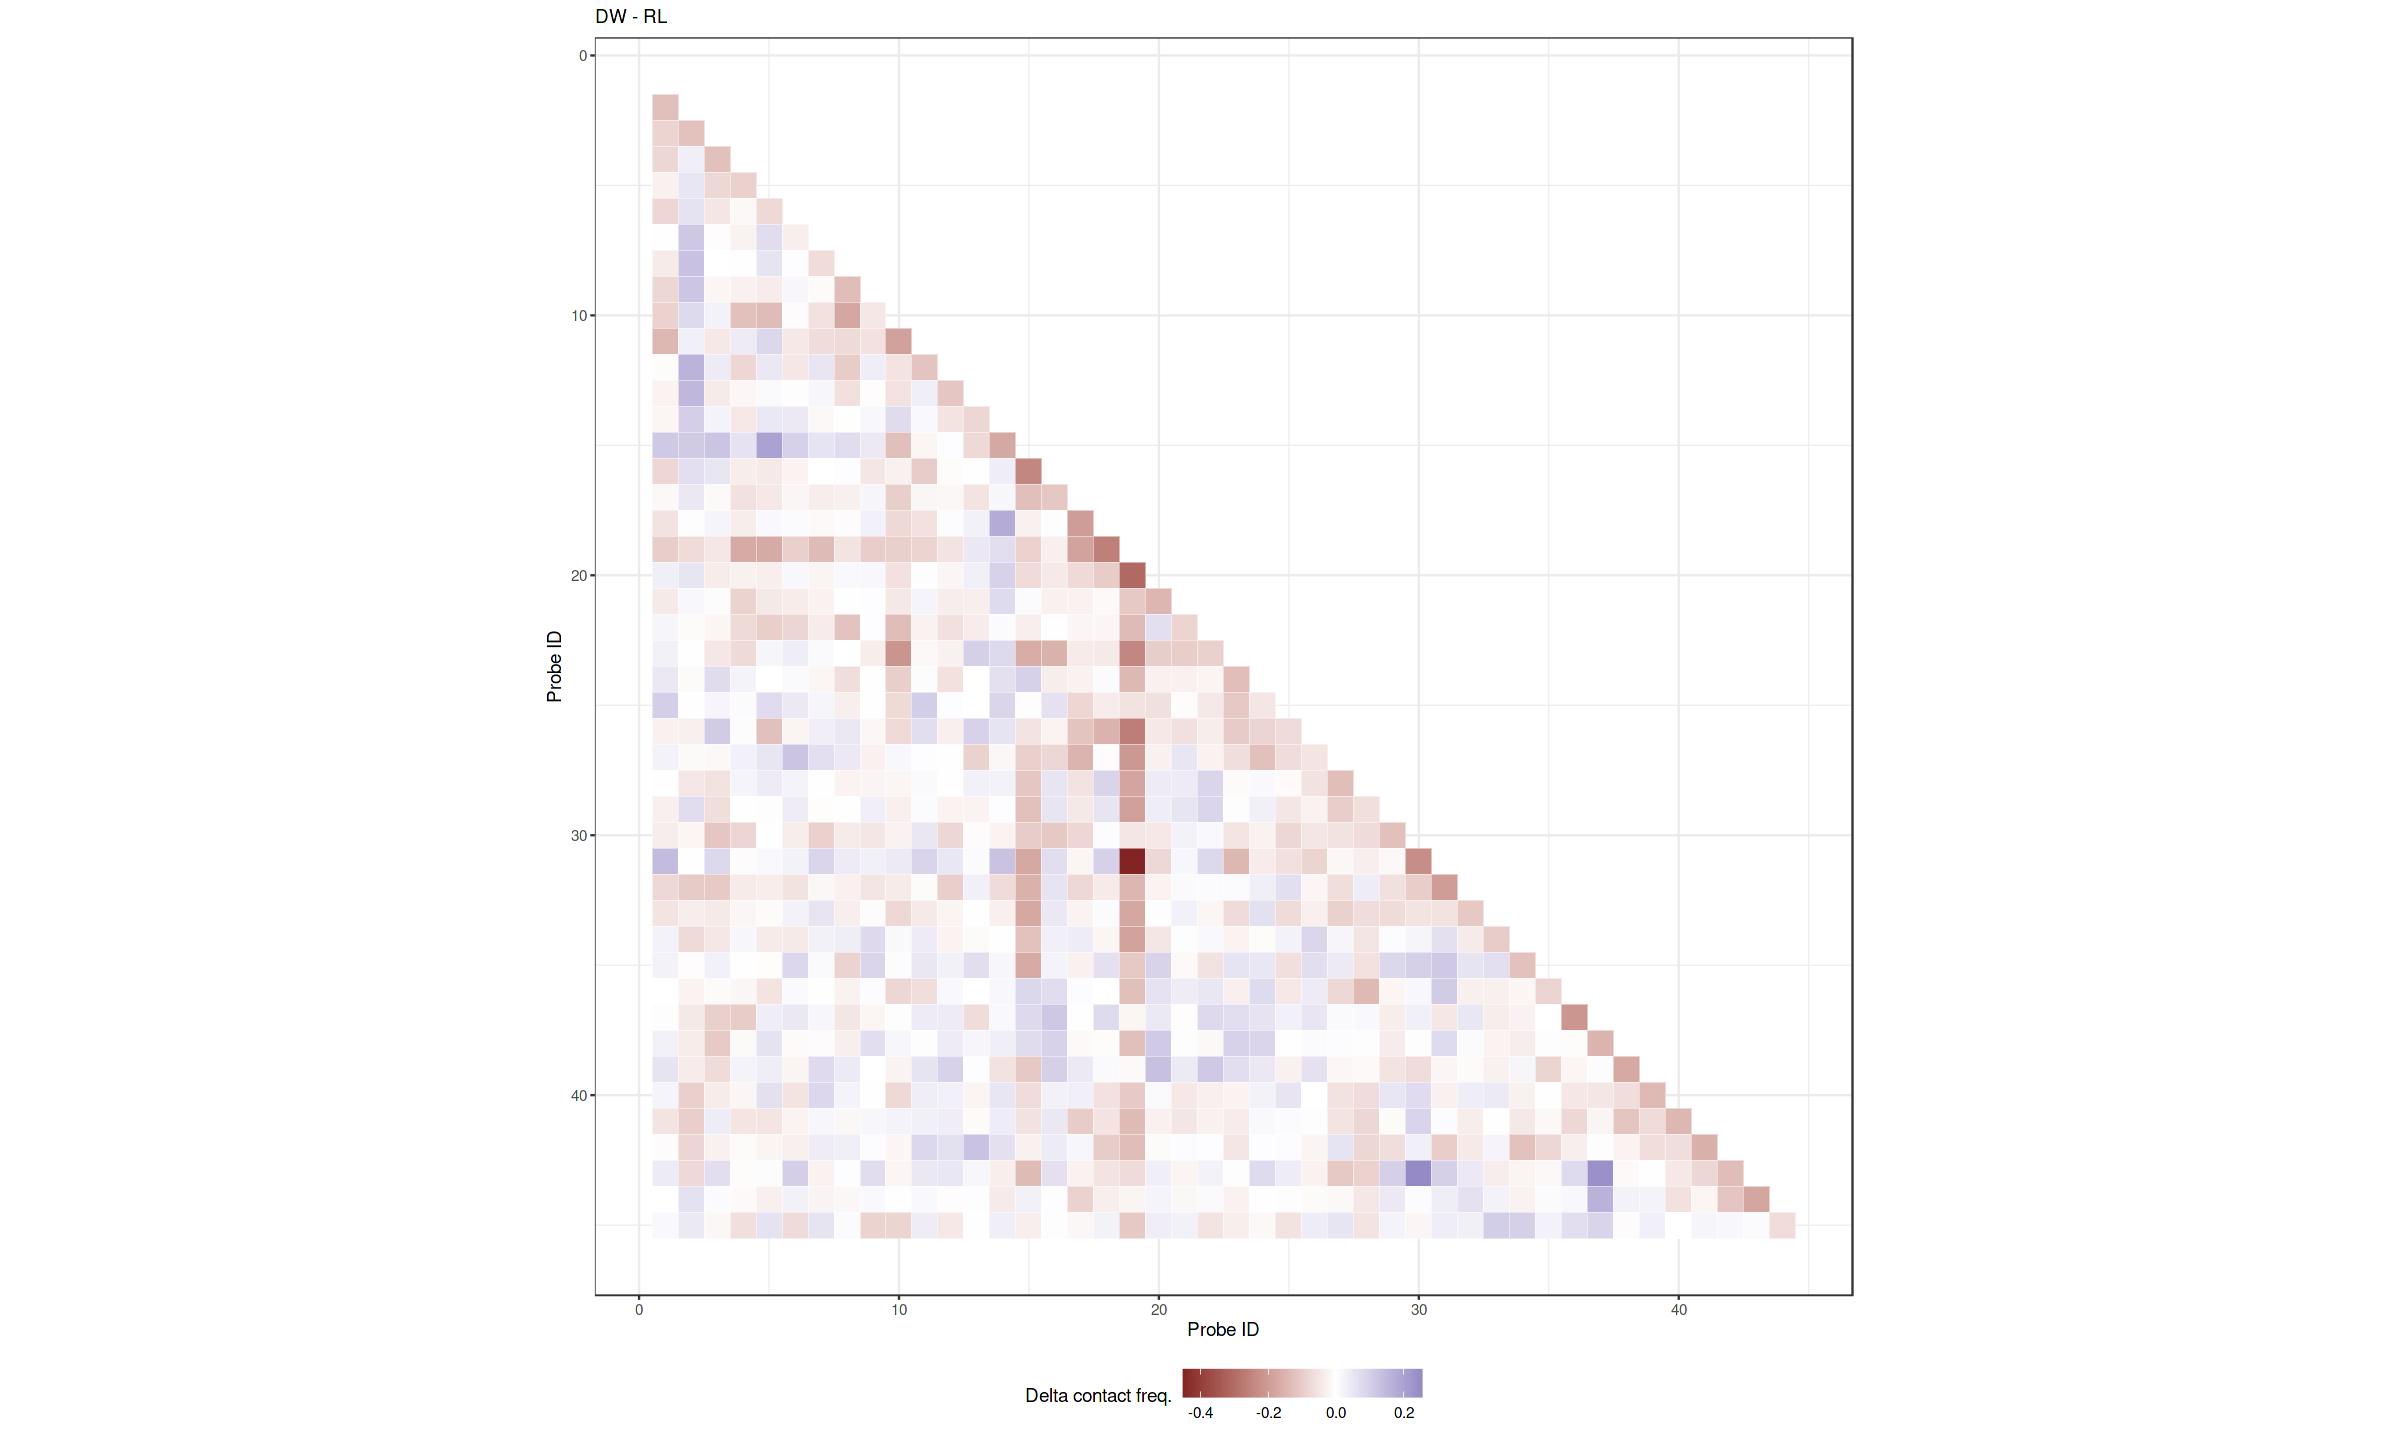

In [88]:
p = ggplot(dcast(hmdata, A+B~method, value.var="fcontacts")[A<B], aes(x=A, y=B, fill=DW-RL)) + geom_tile(color="white") +
    coord_fixed() + theme_bw() + scale_y_reverse() +
    scale_fill_gradient2() + labs(x="Probe ID", y="Probe ID", fill="Delta contact freq.") +
    labs(subtitle="DW - RL") + theme(legend.position="bottom") + guides(fill=guide_colorbar(barwidth=10))
print(p)
save_and_plot(p, "plots/heatmap_cmp.contact_freq.delta", height=12, width=10, formats=c("jpg", "png", "pdf"))

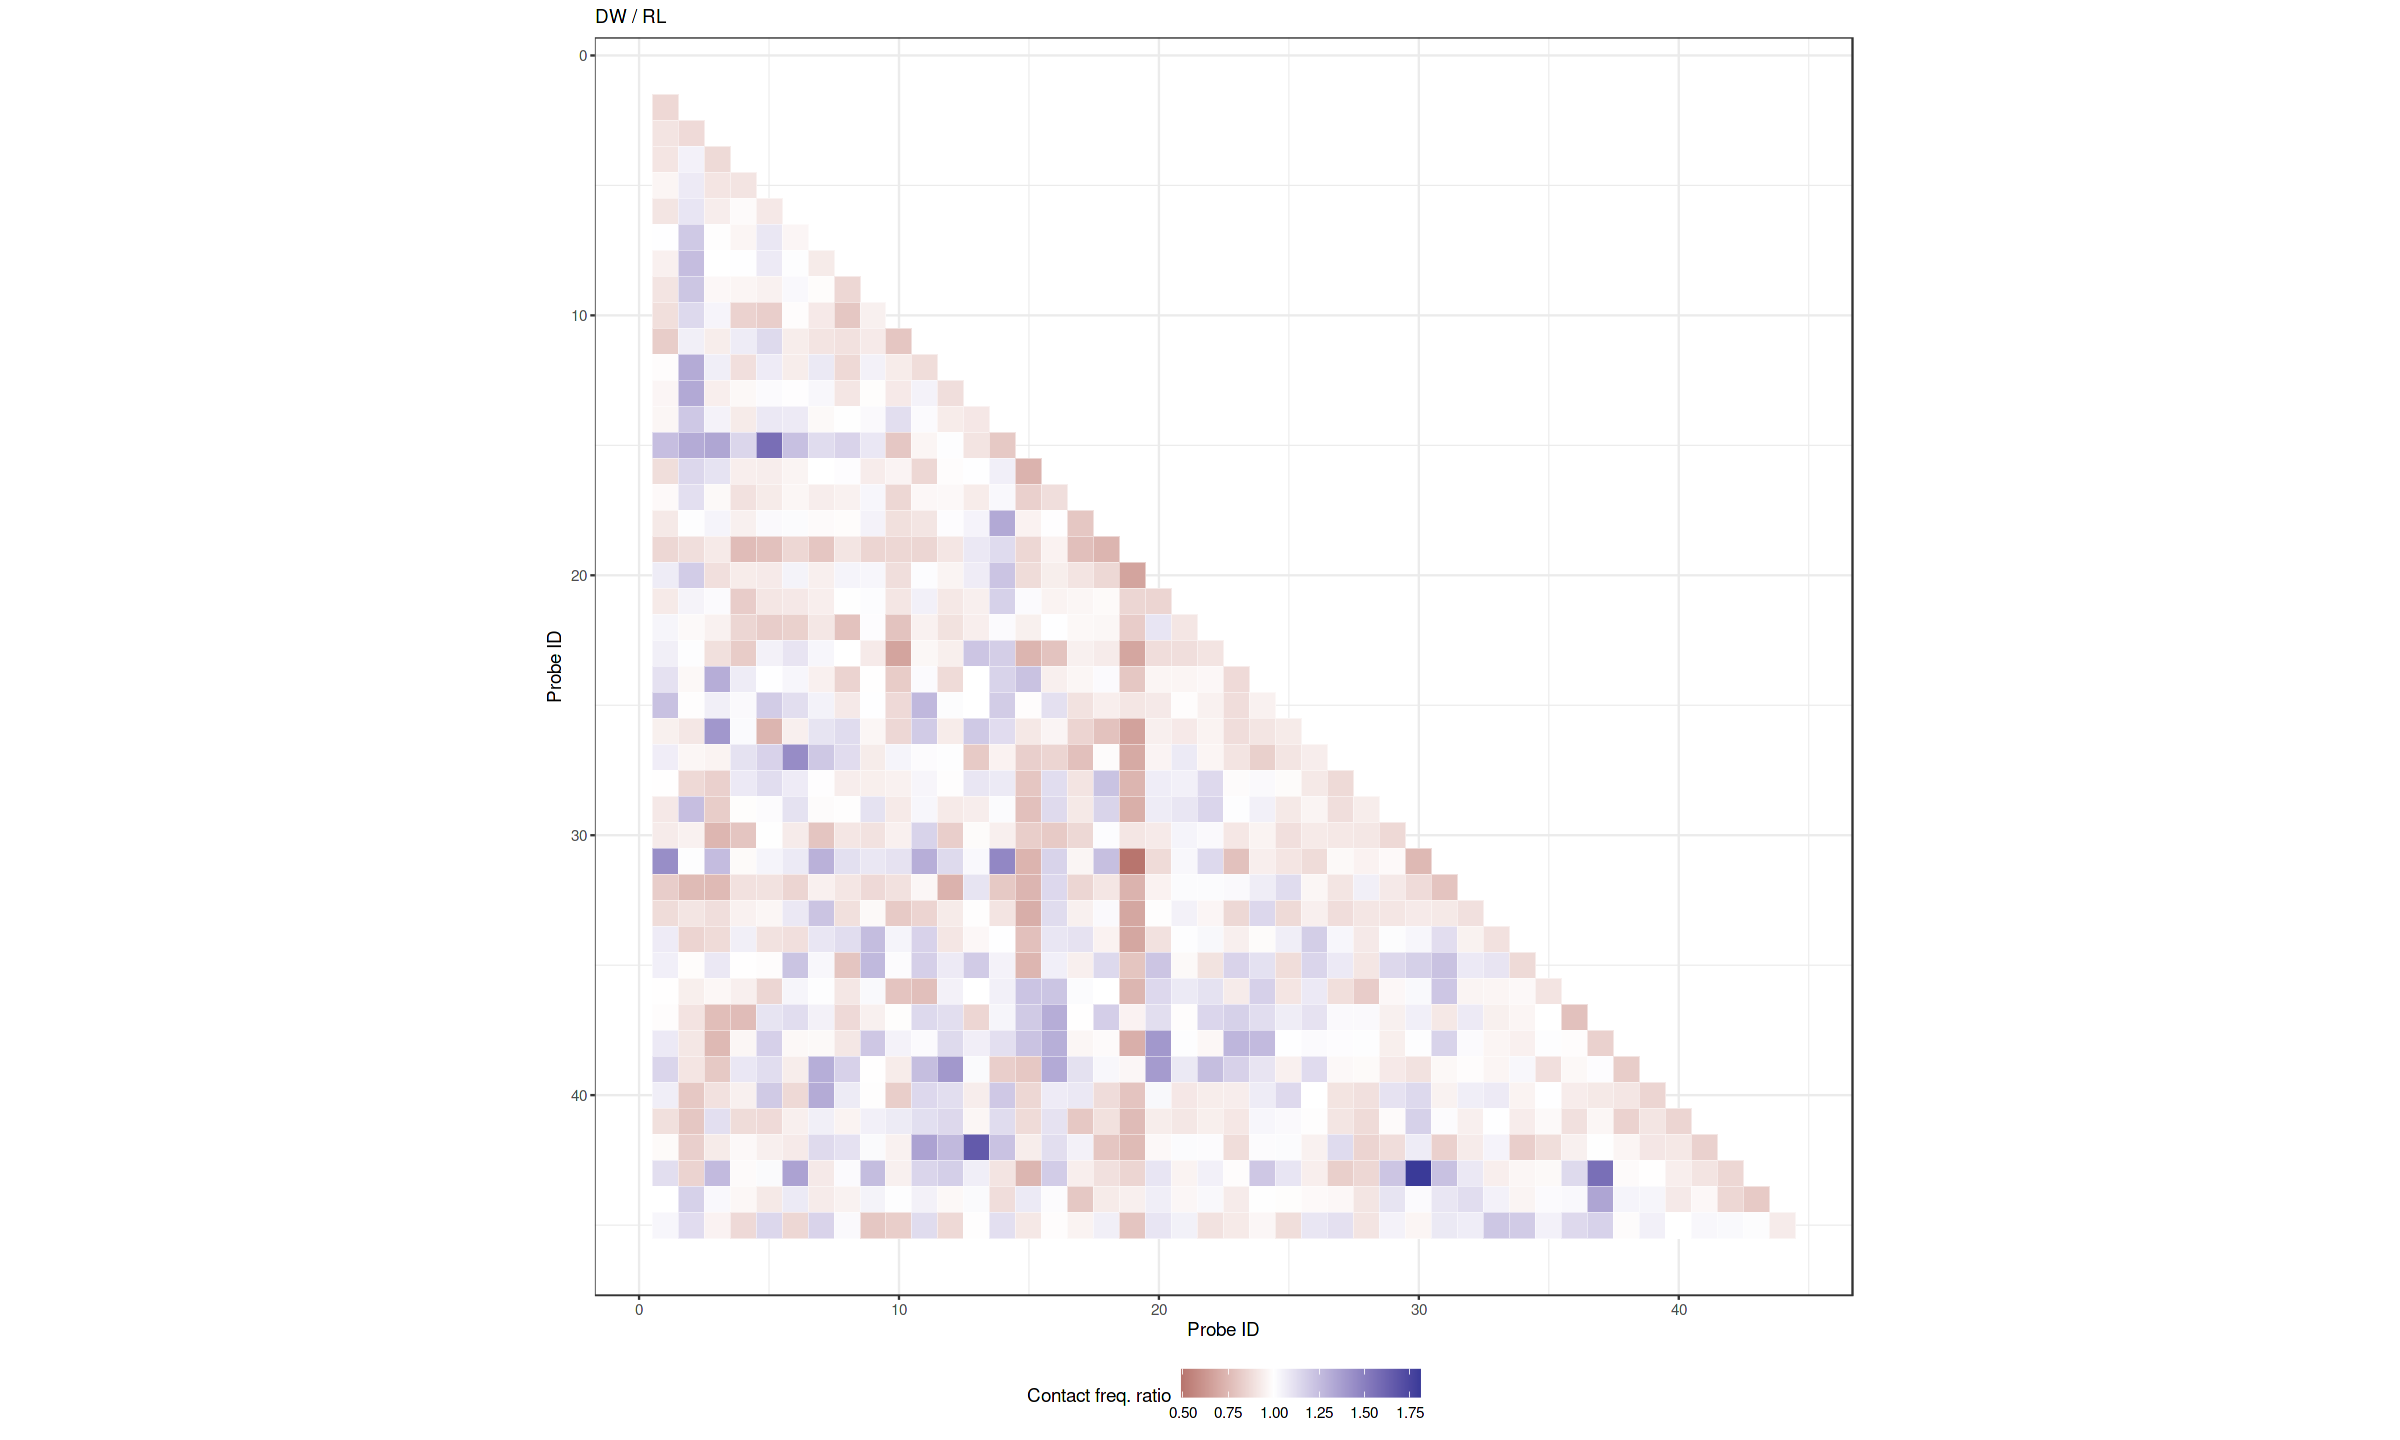

In [89]:
p = ggplot(dcast(hmdata, A+B~method, value.var="fcontacts")[A<B], aes(x=A, y=B, fill=DW/RL)) + geom_tile(color="white") +
    coord_fixed() + theme_bw() + scale_y_reverse() +
    scale_fill_gradient2(midpoint=1) + labs(x="Probe ID", y="Probe ID", fill="Contact freq. ratio") +
    labs(subtitle="DW / RL") + theme(legend.position="bottom") + guides(fill=guide_colorbar(barwidth=10))
print(p)
save_and_plot(p, "plots/heatmap_cmp.contact_freq.ratio", height=12, width=10, formats=c("jpg", "png", "pdf"))

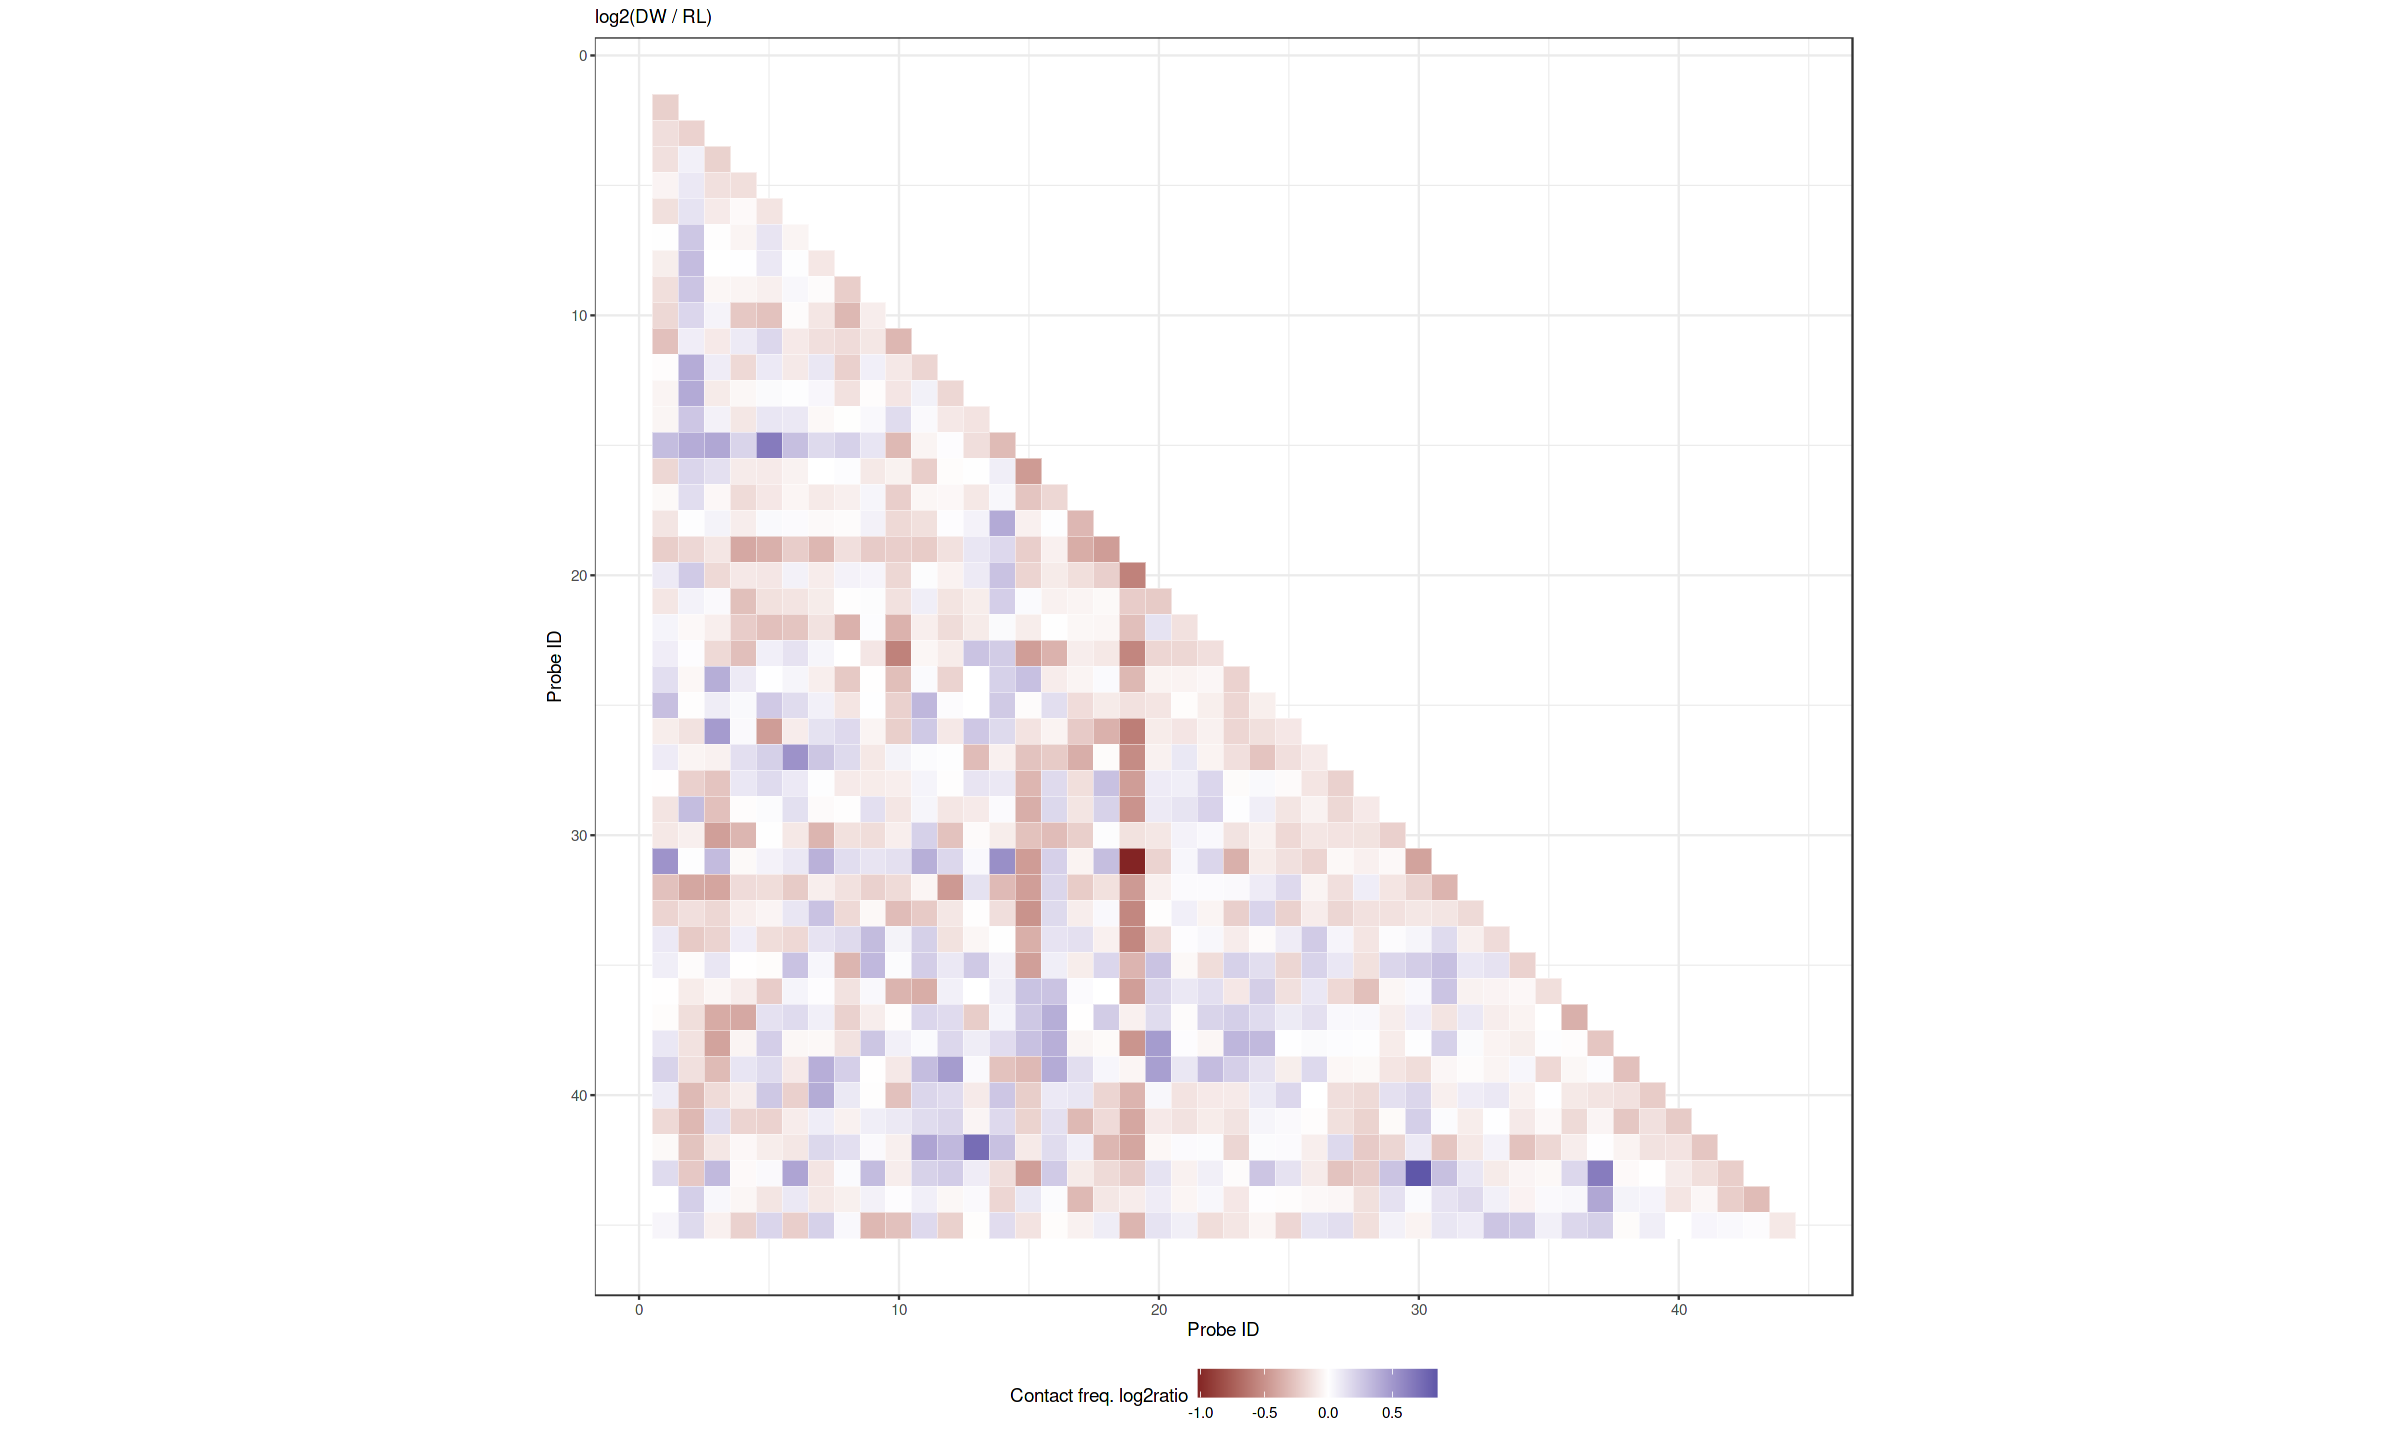

In [90]:
p = ggplot(dcast(hmdata, A+B~method, value.var="fcontacts")[A<B], aes(x=A, y=B, fill=log2(DW/RL))) + geom_tile(color="white") +
    coord_fixed() + theme_bw() + scale_y_reverse() +
    scale_fill_gradient2() + labs(x="Probe ID", y="Probe ID", fill="Contact freq. log2ratio") +
    labs(subtitle="log2(DW / RL)") + theme(legend.position="bottom") + guides(fill=guide_colorbar(barwidth=10))
print(p)
save_and_plot(p, "plots/heatmap_cmp.contact_freq.log2ratio", height=12, width=10, formats=c("jpg", "png", "pdf"))

## Hi-C frequency and contact frequency from OligoFISSEQ, using DW or RL

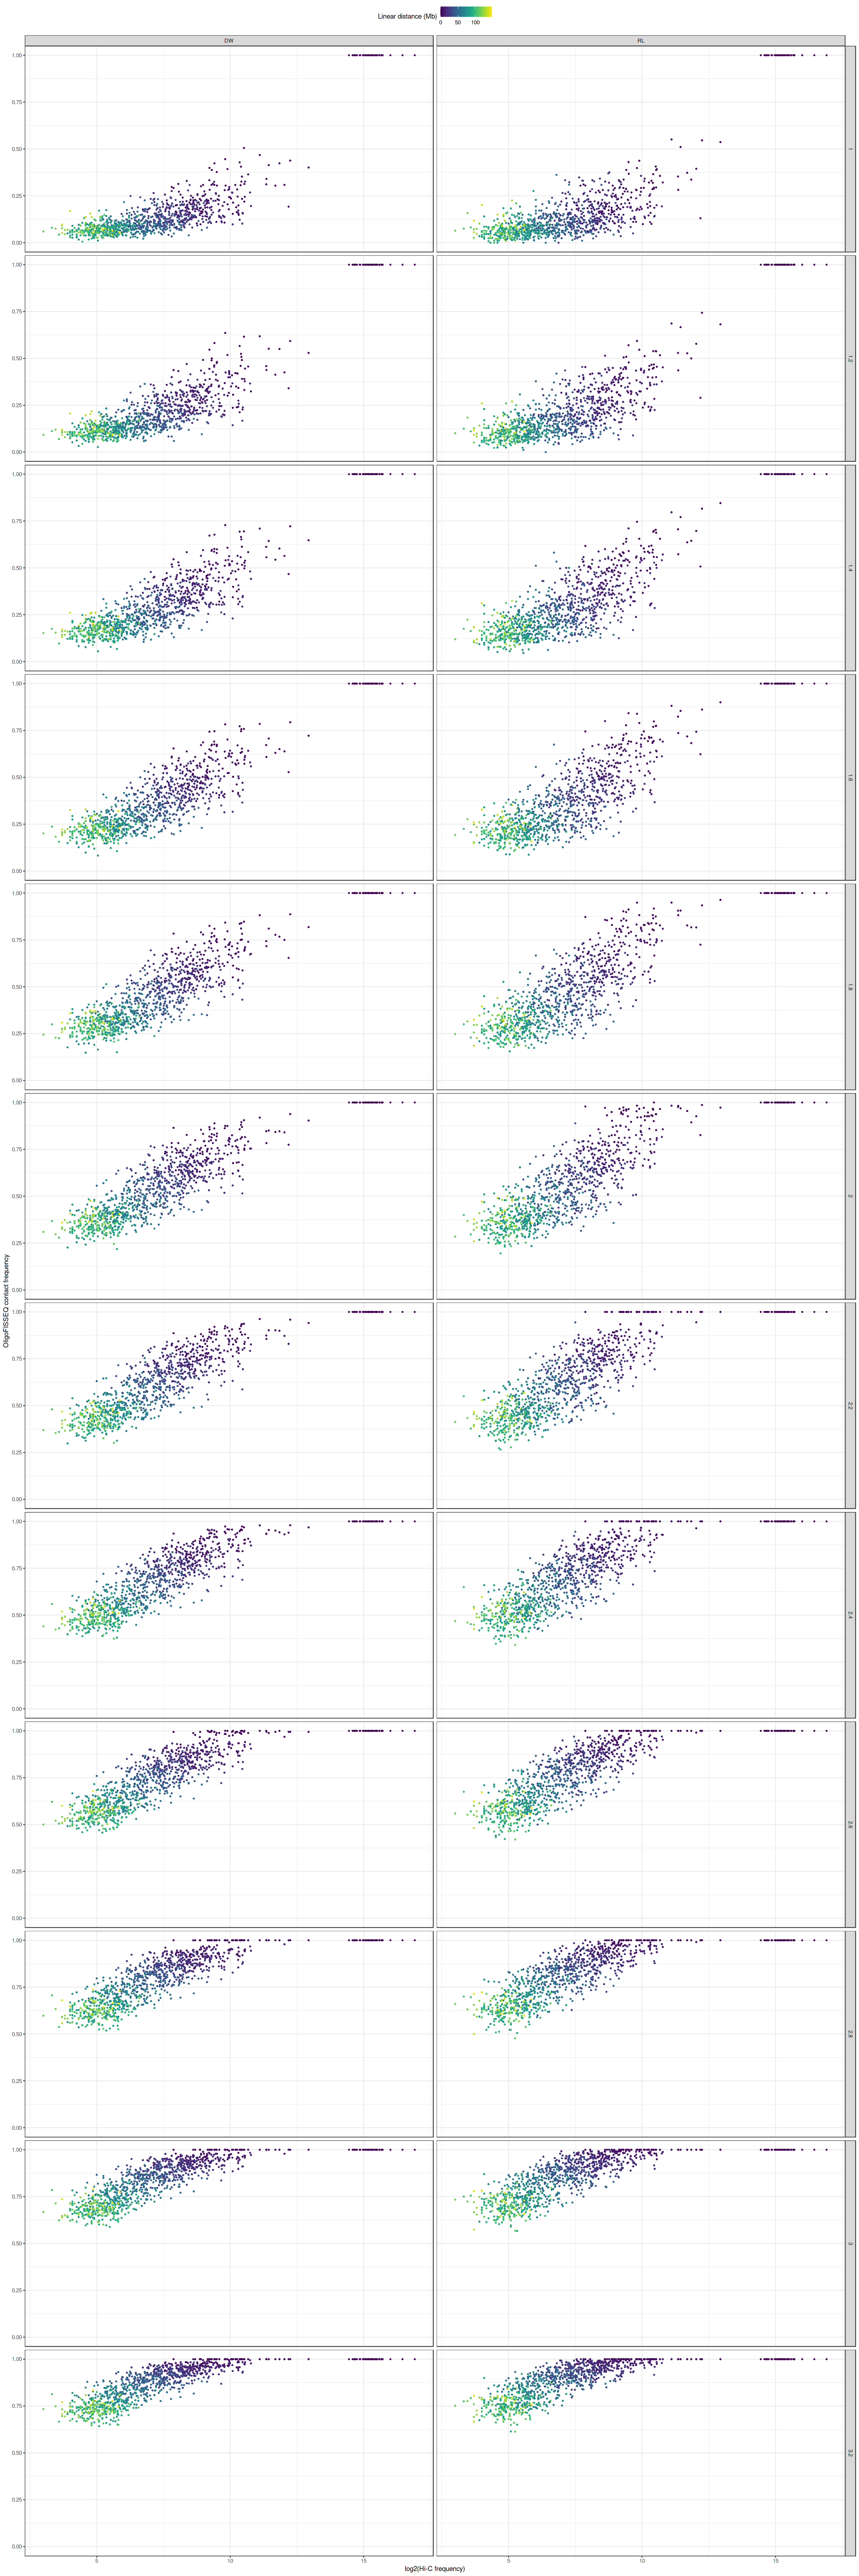

In [21]:
options(repr.plot.width=20, repr.plot.height=60)
ggplot(cdata, aes(x=hic_freq, y=fcontacts, color=dlinear/1e6)) + geom_point(size=.5) + facet_grid(~thr~method) +
    theme_bw() + labs(x="log2(Hi-C frequency)", y="OligoFISSEQ contact frequency", color="Linear distance (Mb)") +
    theme(legend.position="top") + scale_color_viridis()

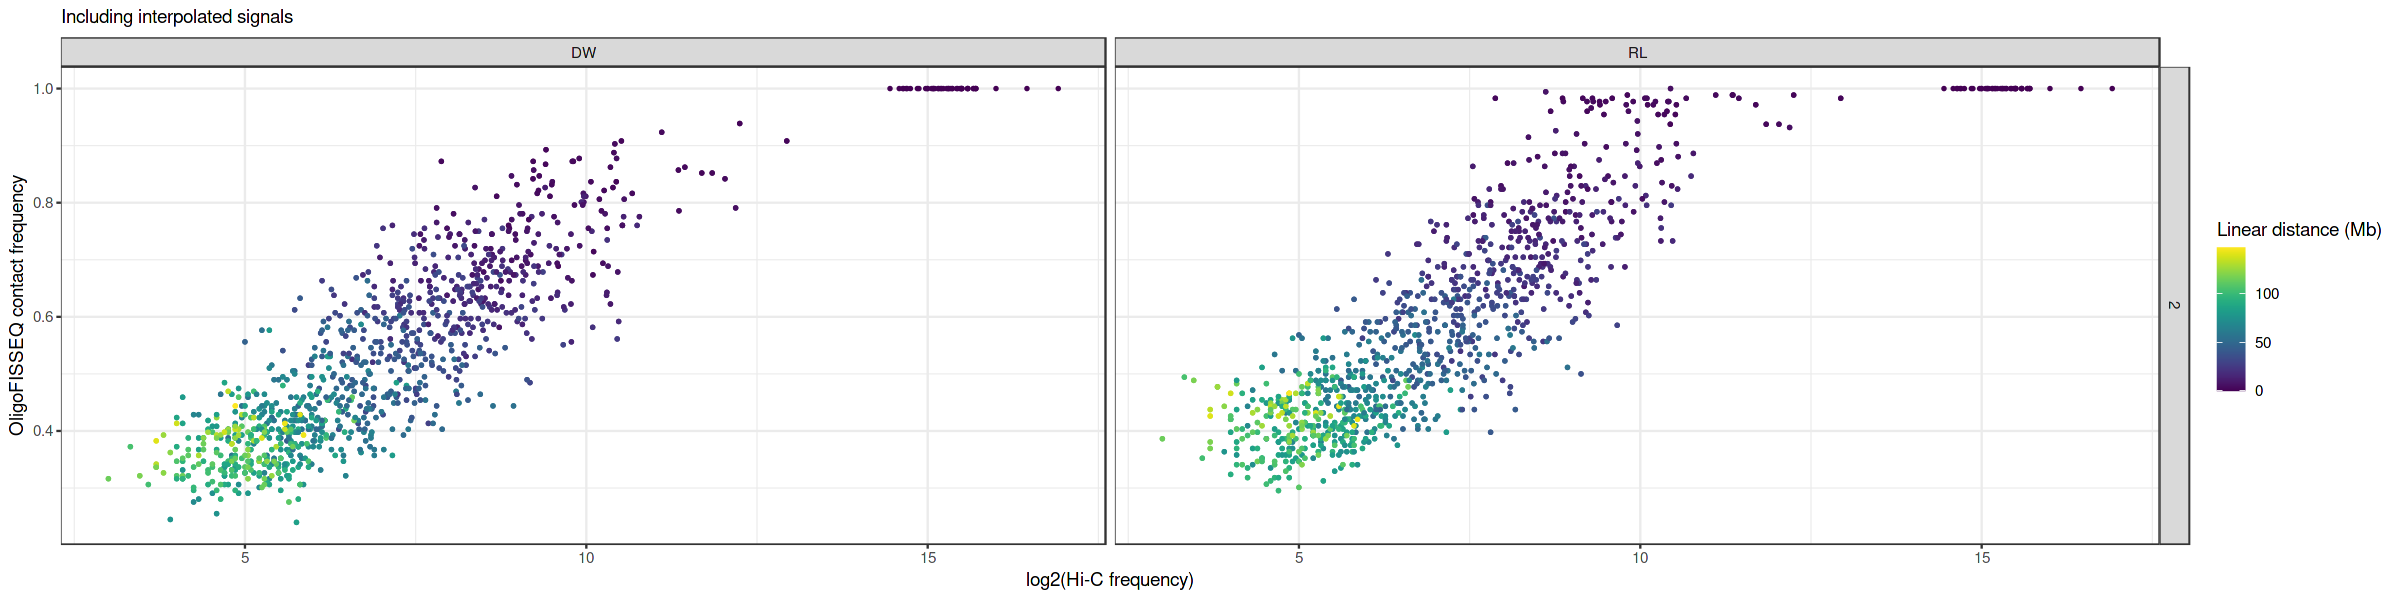

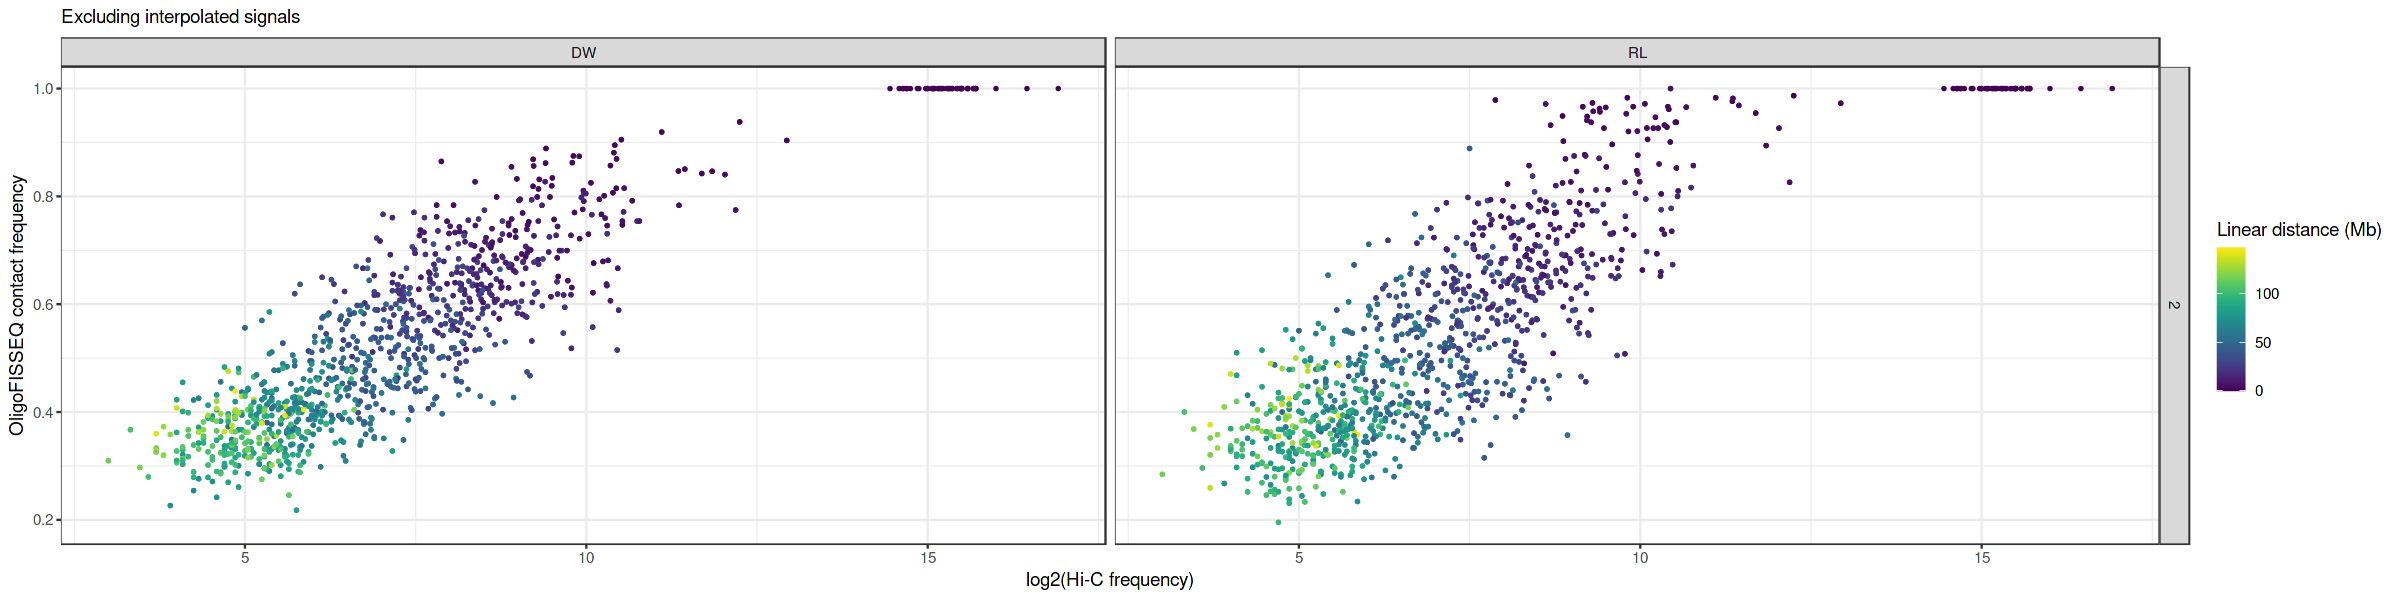

In [22]:
options(repr.plot.width=20, repr.plot.height=5)
ggplot(cdata0[thr==2], aes(x=hic_freq, y=fcontacts, color=dlinear/1e6)) + geom_point(size=.5) + facet_grid(~thr~method) +
    theme_bw() + labs(x="log2(Hi-C frequency)", y="OligoFISSEQ contact frequency", color="Linear distance (Mb)", subtitle="Including interpolated signals") +
    theme(legend.position="right") + scale_color_viridis()
ggplot(cdata[thr==2], aes(x=hic_freq, y=fcontacts, color=dlinear/1e6)) + geom_point(size=.5) + facet_grid(~thr~method) +
    theme_bw() + labs(x="log2(Hi-C frequency)", y="OligoFISSEQ contact frequency", color="Linear distance (Mb)", subtitle="Excluding interpolated signals") +
    theme(legend.position="right") + scale_color_viridis()

## Direct comparison of contact frequency at different contact thresholds

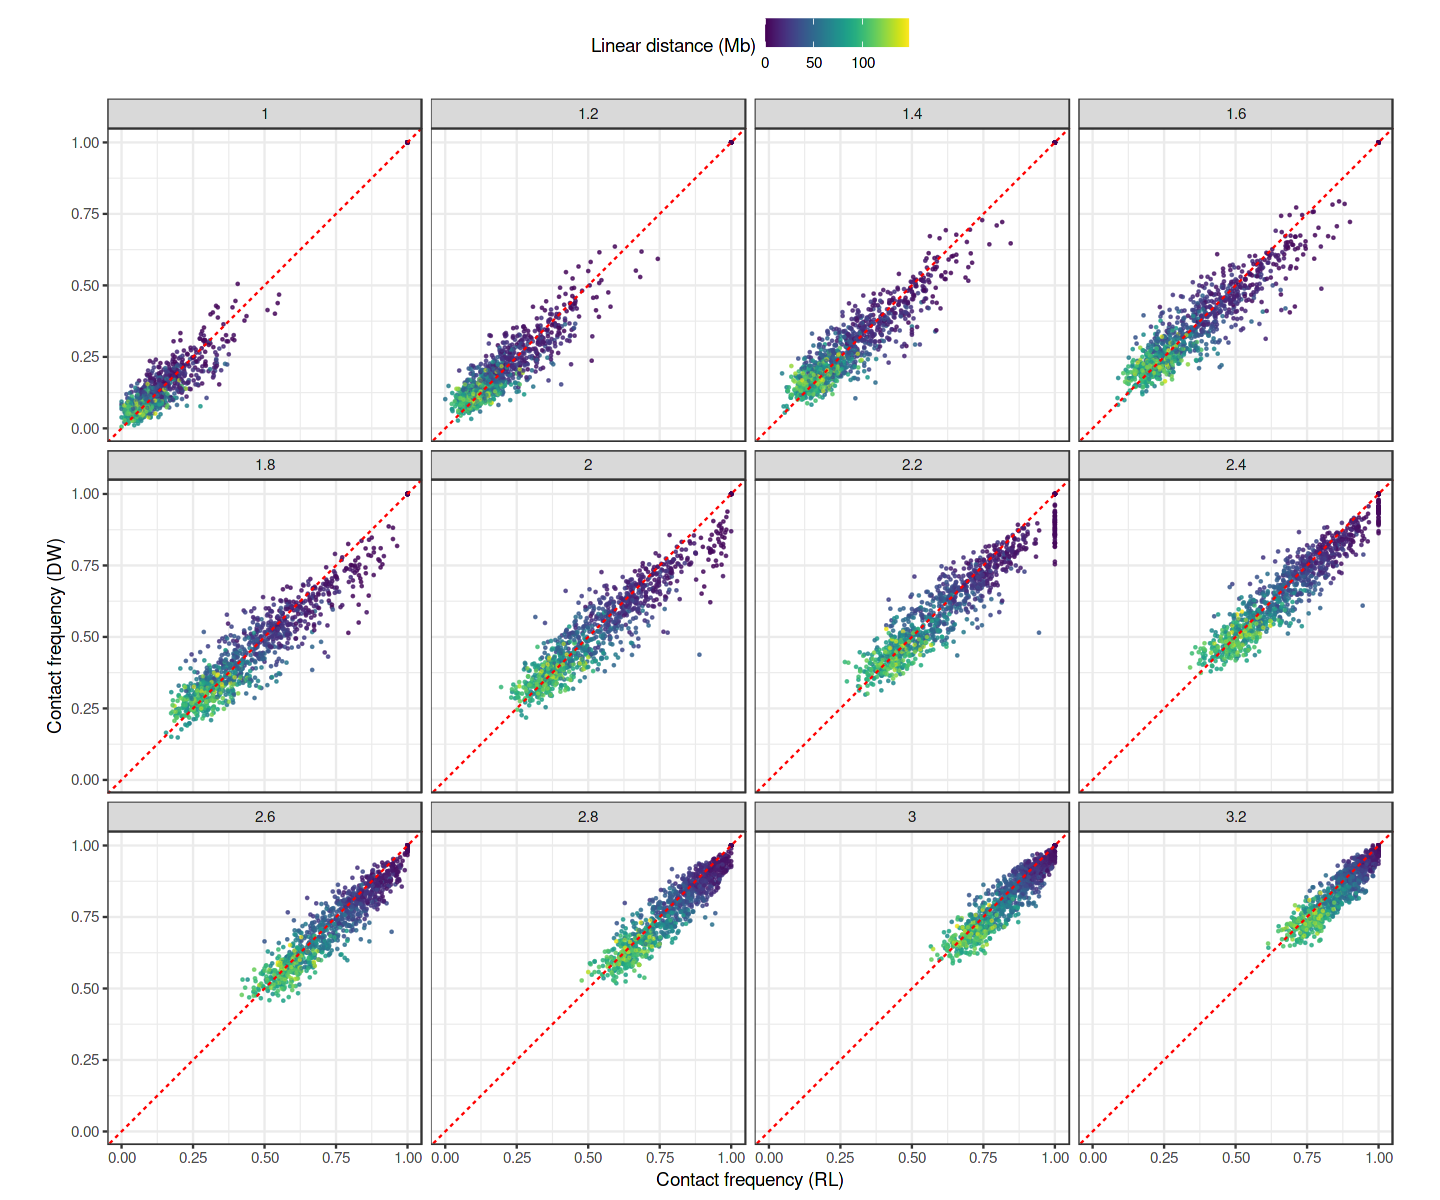

In [23]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(dcast(cdata, A+B+hic_freq+dlinear+thr~method, value.var="fcontacts"), aes(RL, DW, color=dlinear/1e6)) +
    geom_point(size=.25, alpha=.5) + facet_wrap(~thr) + theme_bw() +
    geom_abline(slope=1, color="red", linetype="dashed") + coord_fixed() +
    scale_color_viridis() + labs(x="Contact frequency (RL)", y="Contact frequency (DW)", color="Linear distance (Mb)") +
    theme(legend.position="top")

## Correlation near-diagonal

In [24]:
nddata0 = cdata0[dlinear != 0 & fcontacts != 1][, .(A, B, hic_freq, fcontacts, dlinear, q=ecdf(hic_freq)(hic_freq)), by=c("thr", "method")]
nddata = cdata[dlinear != 0 & fcontacts != 1][, .(A, B, hic_freq, fcontacts, dlinear, q=ecdf(hic_freq)(hic_freq)), by=c("thr", "method")]

In [25]:
ndcordata = rbindlist(pblapply(seq(.5, .95, by=.05), function(qthr) {
    nddata[q >= qthr, .(qthr, PCC=cor(hic_freq, fcontacts), SCC=cor(hic_freq, fcontacts, method="spearman")), by=c("thr", "method")]
}))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


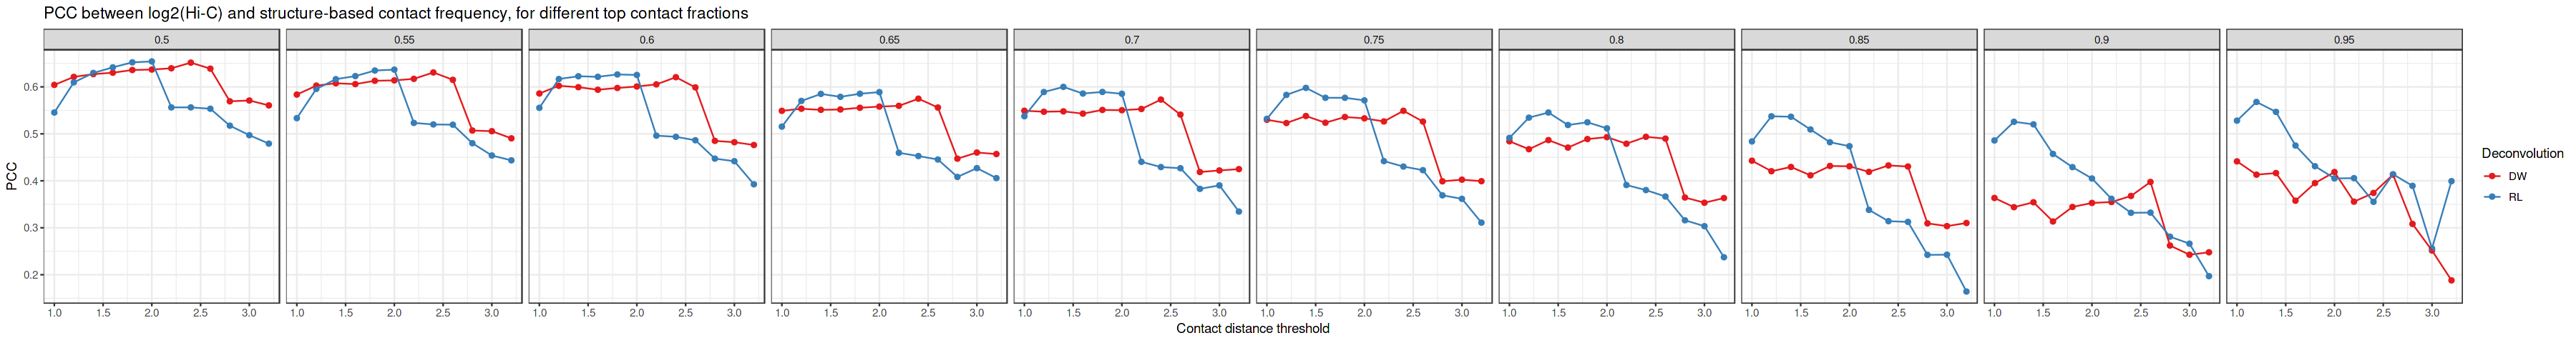

In [26]:
options(repr.plot.width=30, repr.plot.height=4)
ggplot(ndcordata, aes(x=thr, y=PCC, color=method)) + geom_point() + geom_line() + facet_grid(~qthr) +
    theme_bw() + scale_color_brewer(palette="Set1") + labs(x="Contact distance threshold", color="Deconvolution") +
    labs(title="PCC between log2(Hi-C) and structure-based contact frequency, for different top contact fractions")

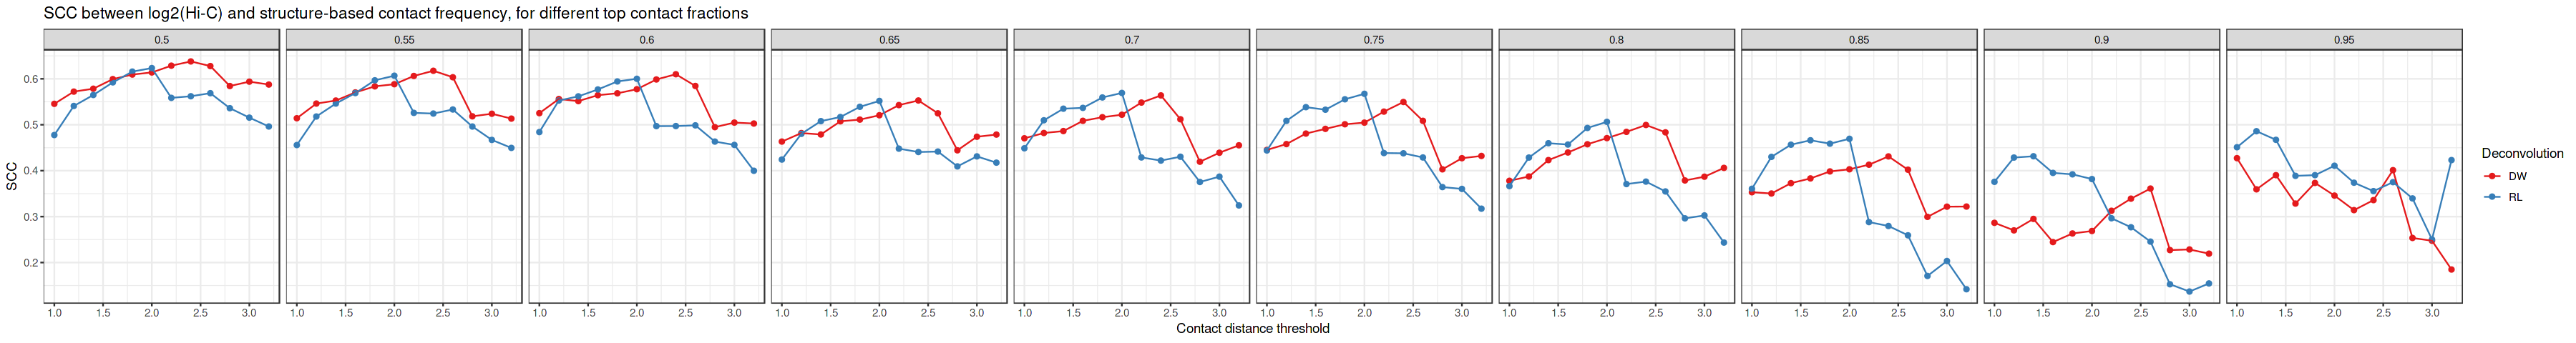

In [27]:
options(repr.plot.width=30, repr.plot.height=4)
ggplot(ndcordata, aes(x=thr, y=SCC, color=method)) + geom_point() + geom_line() + facet_grid(~qthr) +
    theme_bw() + scale_color_brewer(palette="Set1") + labs(x="Contact distance threshold", color="Deconvolution") +
    labs(title="SCC between log2(Hi-C) and structure-based contact frequency, for different top contact fractions")

## Structure-based contact frequency decay with linear distance

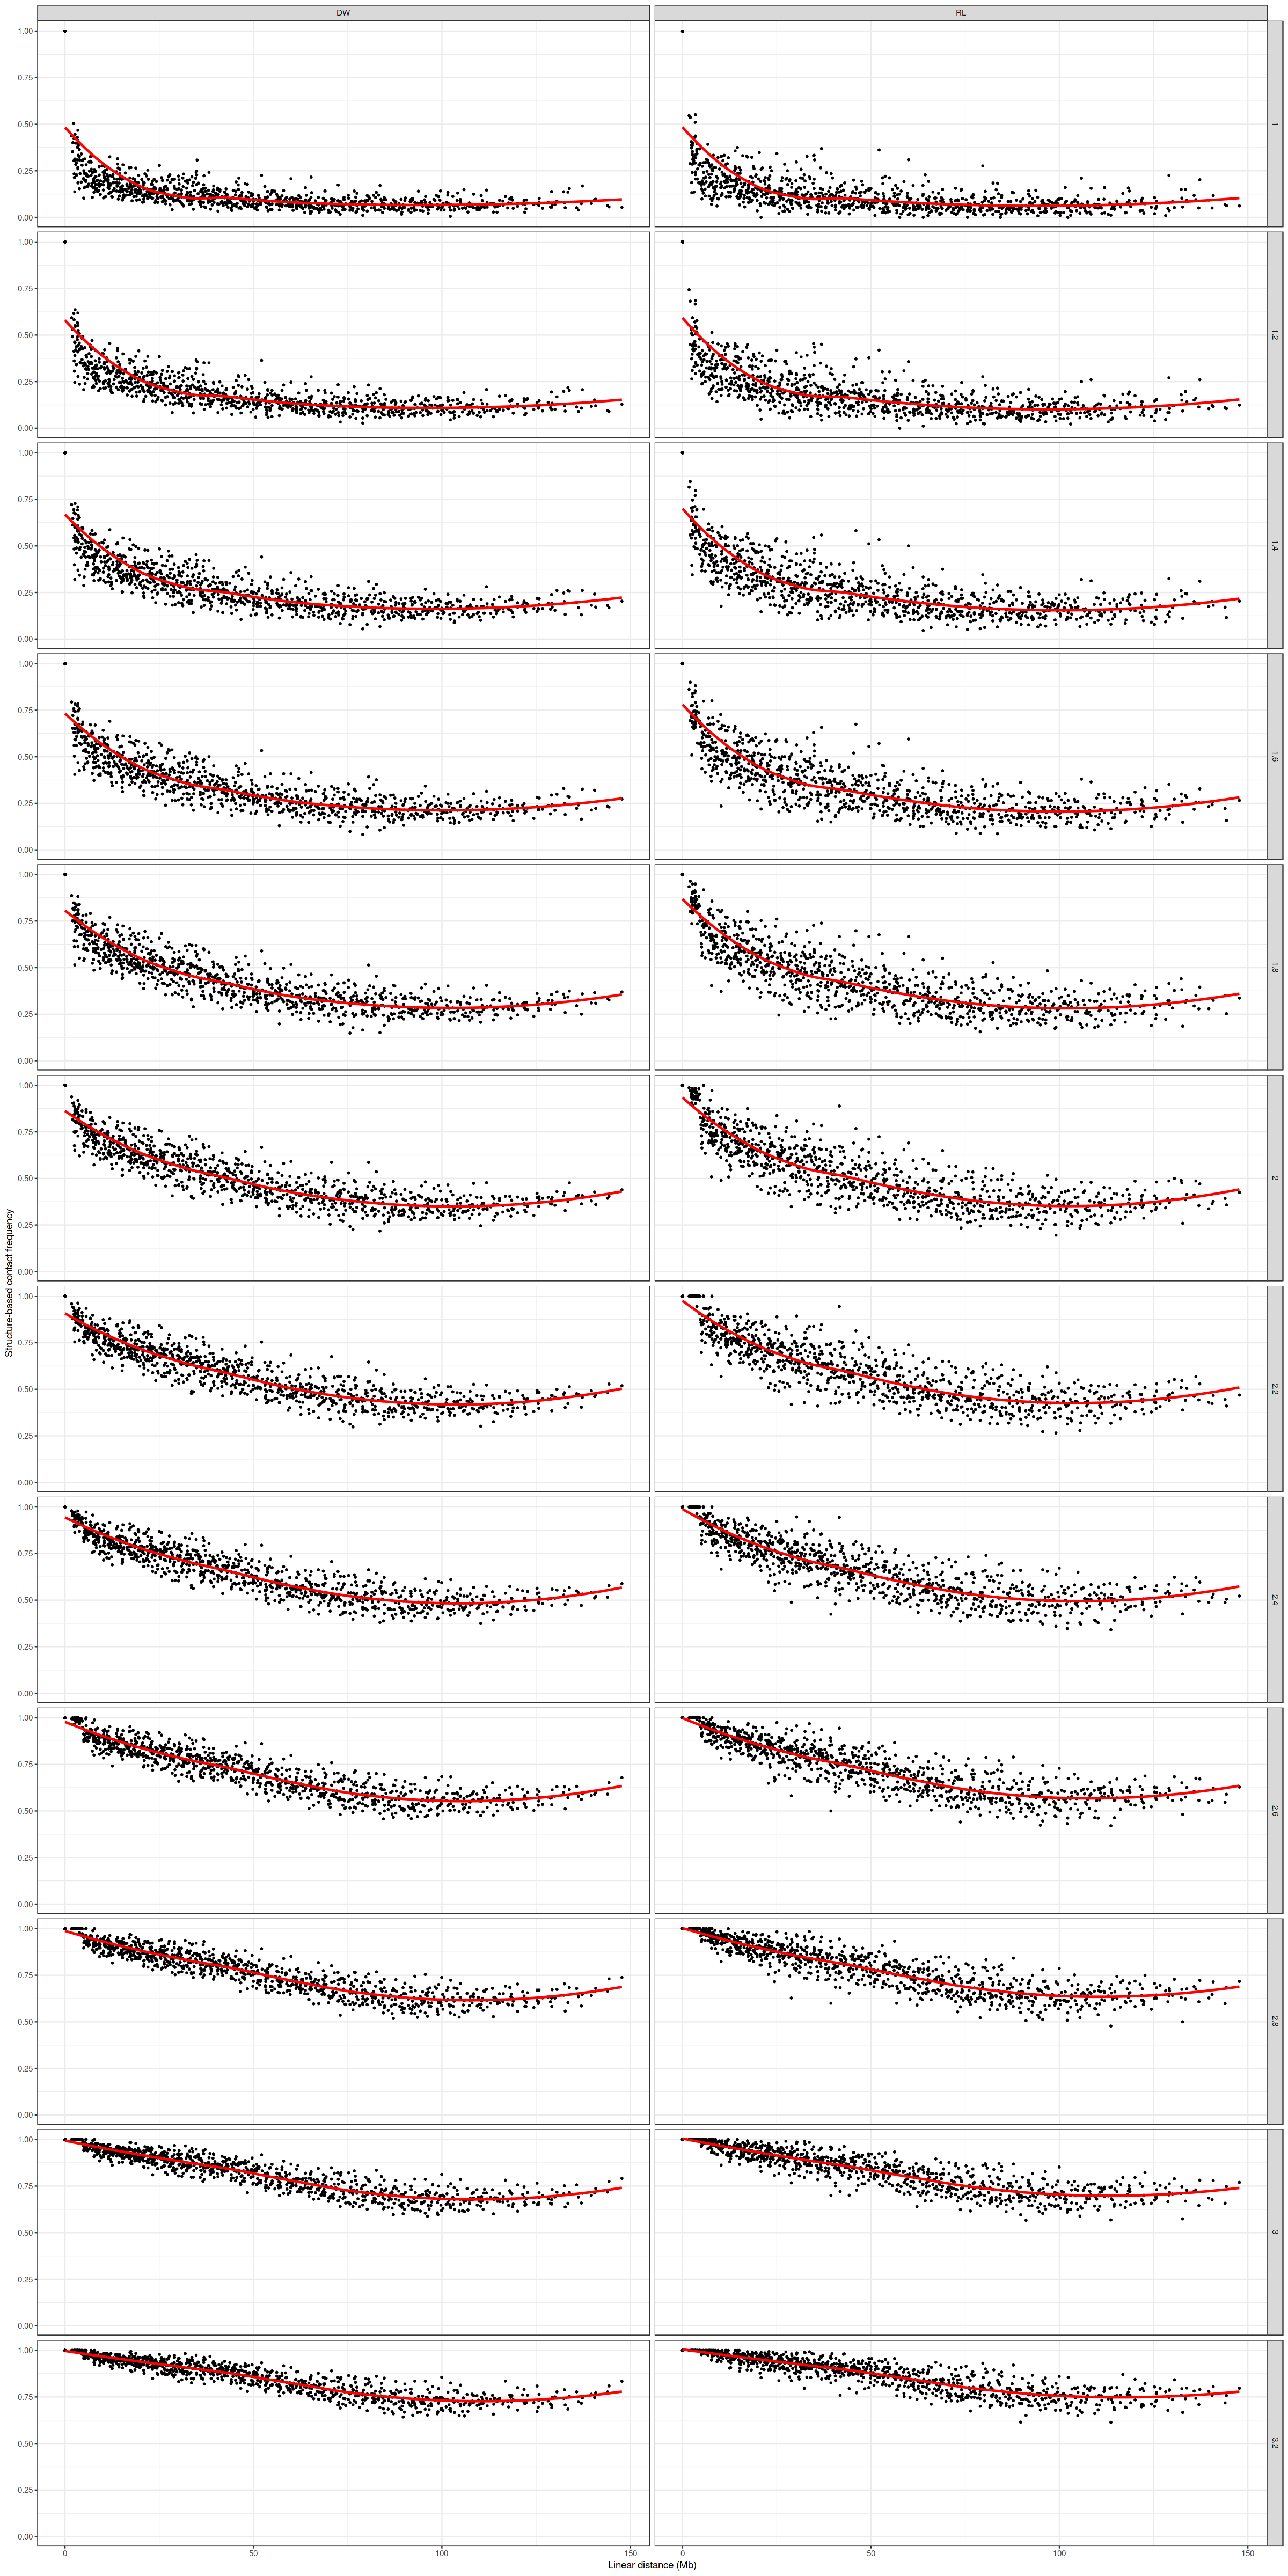

In [28]:
options(repr.plot.width=20, repr.plot.height=40)
ggplot(cdata, aes(x=dlinear/1e6, y=fcontacts)) + geom_point(size=.5) +
    facet_grid(~thr~method) + geom_smooth(se=F, color="red", method="loess", formula="y~x") +
    theme_bw() + labs(x="Linear distance (Mb)", y="Structure-based contact frequency")

Same plot from Hi-C

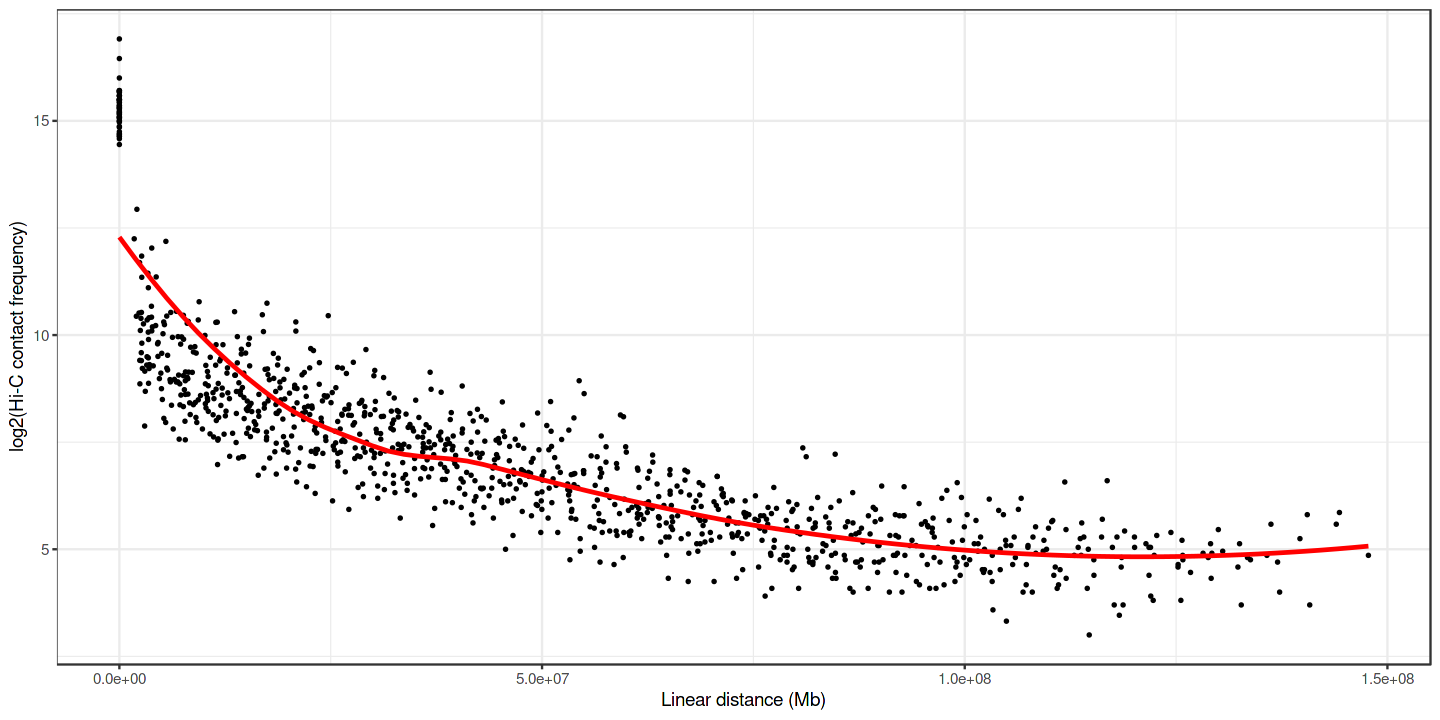

In [29]:
options(repr.plot.width=12, repr.plot.height=6)
ggplot(unique(cdata[, .(hic_freq, dlinear)]), aes(dlinear, hic_freq)) + geom_point(size=.5) +
    geom_smooth(se=F, color="red", method="loess", formula="y~x") +
    theme_bw() + labs(x="Linear distance (Mb)", y="log2(Hi-C contact frequency)")